# Exploring Slot Machine Data

### 요약
이 노트북의 목적은 [Data_Wrangling.ipynb](https://github.com/Jaepal/data-science-portfolio/blob/master/slot_machine/Data_Wrangling.ipynb)에서 만들어진 데이터의 특징을 탐색하는 것입니다. 데이터를 탐색하고, 이를 토대로 [게임 모델](https://github.com/Jaepal/data-science-portfolio/blob/master/slot_machine/slot.py)을 만들고 [Data_Modeling.ipynb](https://github.com/Jaepal/data-science-portfolio/blob/master/slot_machine/Data_Modeling.ipynb)에서 Multi-armed bandit 알고리즘을 통해 어느 Machine의 RTP가 가장 높은지 알아볼 것입니다.

### 시각화 내용
#### Platinum Slot
1. 각 Symbol의 출현 빈도
2. RICHHITS의 빈도
3. reel의 유형
4. unique한 symbol의 수

In [2]:
# 필요한 패키지 불러오기

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import seaborn as sns
import scipy.stats as st

sns.set(style="darkgrid", font_scale=2)

%matplotlib inline

## Platinum Slot

In [35]:
pl_labels = ['10', 'J', 'Q', 'K', 'A', 'Ca', 'Co', 'D', 'Cr', 'W', 'R']

In [36]:
# csv 파일 불러오기

pl_slot_result = pd.read_csv('../data/slot_machine/platinum_csv/pl_all.csv')
pl_slot_result.head()

,img,classname
0,platinum_0_0.jpg,Ca
1,platinum_0_1.jpg,A
2,platinum_0_2.jpg,Q
3,platinum_0_3.jpg,W
4,platinum_0_4.jpg,A


In [37]:
# 각 칸의 결과마다 game, row, col column 생성

pl_slot_result_game = [int(i_name.split('_')[1]) for n, i_name in enumerate(pl_slot_result['img'])]
pl_slot_result_row = [int(i_name.split('_')[2].split('.')[0]) % 3 + 1 for n, i_name in enumerate(pl_slot_result['img'])]
pl_slot_result_col = [int(i_name.split('_')[2].split('.')[0]) // 3 + 1 for n, i_name in enumerate(pl_slot_result['img'])]

pl_slot_result['game'] = pl_slot_result_game
pl_slot_result['row'] = pl_slot_result_row
pl_slot_result['col'] = pl_slot_result_col

pl_slot_result.head(15)

,img,classname,game,row,col
0,platinum_0_0.jpg,Ca,0,1,1
1,platinum_0_1.jpg,A,0,2,1
2,platinum_0_2.jpg,Q,0,3,1
3,platinum_0_3.jpg,W,0,1,2
4,platinum_0_4.jpg,A,0,2,2
5,platinum_0_5.jpg,A,0,3,2
6,platinum_0_6.jpg,10,0,1,3
7,platinum_0_7.jpg,Cr,0,2,3
8,platinum_0_8.jpg,Co,0,3,3
9,platinum_0_9.jpg,10,0,1,4


In [38]:
tmp = []
pl_slot_result_per_game = []
for n, x in enumerate(pl_slot_result['classname']):
    tmp.append(x)
    if (n+1) % 15 == 0:
        pl_slot_result_per_game.append(tmp)
        tmp = []

## 1. 각 Symbol의 출현 빈도 확인

In [39]:
# 각 Symbol의 출현 확률의 구체적인 수치 (%)

pl_slot_result['classname'].value_counts() / len(pl_slot_result) * 100

Q     13.236667
10    12.553333
K     12.073333
A     11.506667
J      9.543333
Ca     9.520000
Cr     8.760000
D      8.026667
Co     7.576667
R      4.040000
W      3.163333
Name: classname, dtype: float64

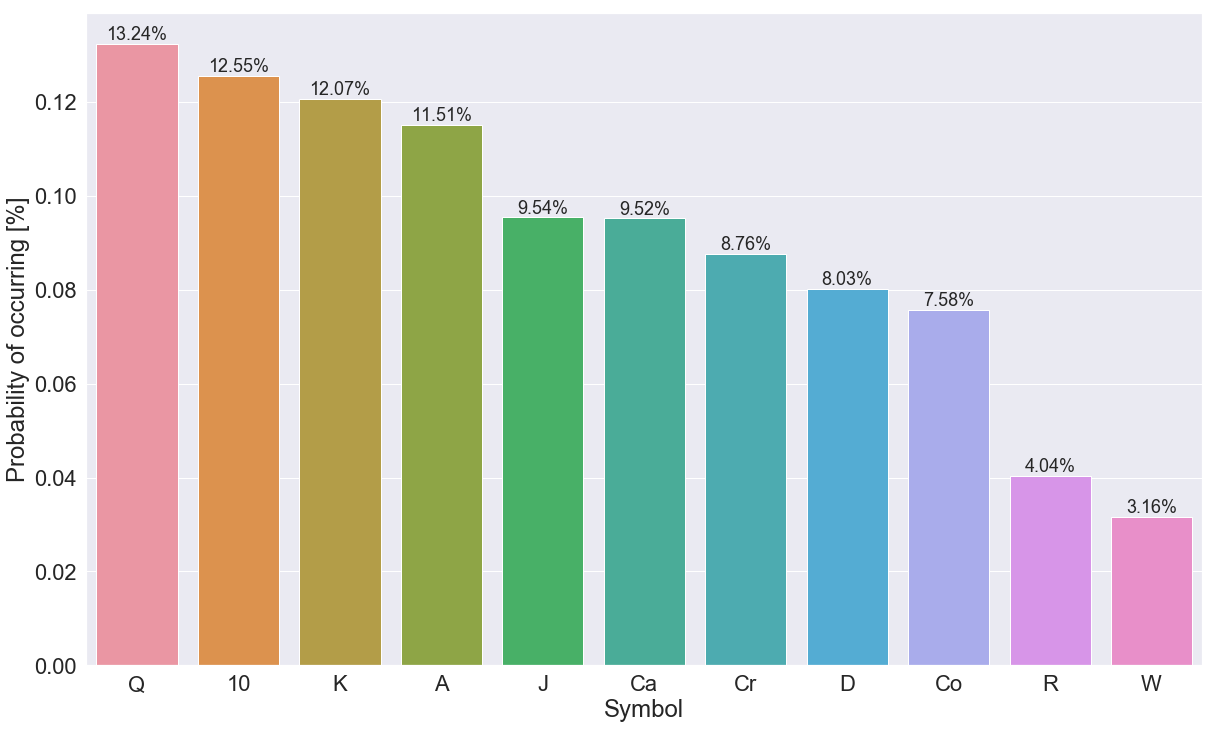

In [40]:
# 각 Symbol의 출현 확률 시각화

plt.figure(figsize=(20,12))
ax = sns.barplot(x=pl_slot_result['classname'].value_counts().index, y=pl_slot_result['classname'].value_counts() / len(pl_slot_result))
plt.xlabel("Symbol")
plt.ylabel("Probability of occurring [%]")


for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.2f}%'.format(y*100), (x.mean(), y), ha='center', va='bottom', fontsize=18) # set the alignment of the text

plt.show()

각 Symbol의 출현 빈도는 Symbol의 낮은 value 순서와 완전히 같지는 않지만 대체로 비슷한 순서를 가지고 있는 것을 볼 수 있습니다.

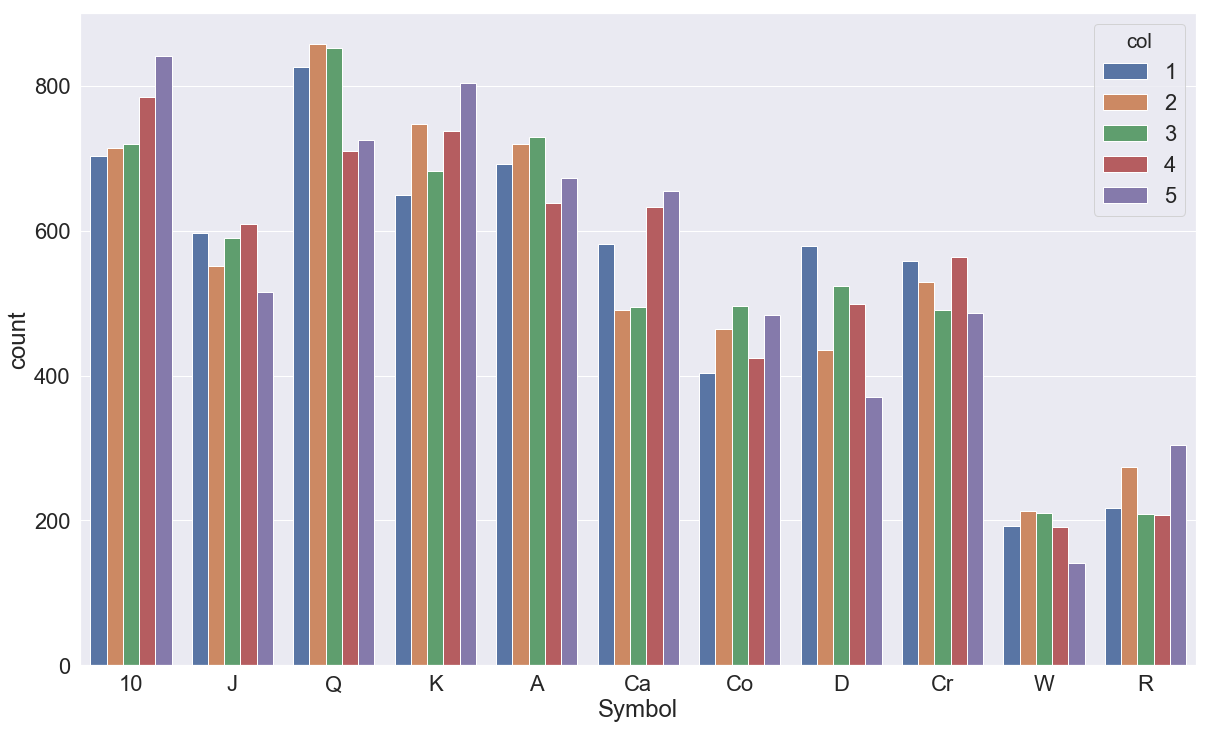

In [9]:
# 각 reel별 출현 횟수 시각화

plt.figure(figsize=(20,12))
sns.countplot(x='classname', data=pl_slot_result, hue='col', order=pl_labels)
plt.xlabel("Symbol")
plt.show()

각 reel(1, 2, 3, 4, 5)마다 Symbol의 빈도가 약간씩은 다르지만 대체로 비슷한 빈도로 나타나는 것을 알 수 있습니다.

## 2. Simulation 데이터 생성
각 15개의 칸이 위의 각 Symbol의 출현 확률을 가지고 완전히 독립적으로 작동한다는 가정 하에 2000번의 Simulation 데이터를 생성하고, 게임 모델을 보완하여 최대한 실제 게임과 가깝게 만들기 위해 실제 게임과의 차이를 확인합니다.

In [10]:
'''
# Baseline Model

2000번의 실제 게임 데이터를 기반으로 각 Symbol의 출현 빈도 설정

# Q   : 13.5 %
# 10  : 12.5 %
# K   : 12 %
# A   : 11.5 %
# J   : 9.5 %
# Ca  : 9.5 %
# Cr  : 9 %
# D   : 8 %
# Co  : 7.5 %
# R   : 4 %
# W   : 3 %
'''

# numpy의 randint를 통해 출현 확률을 기반으로 Symbol을 Return하는 함수

def getPlatinumSymbol(start, end):
    i = np.random.randint(start, end)
    if i <= 27:
        return 'Q'
    elif i <= 52 and i > 27:
        return '10'
    elif i <= 76 and i > 52:
        return 'K'
    elif i <= 99 and i > 76:
        return 'A'
    elif i <= 118 and i > 99:
        return 'J'
    elif i <= 137 and i > 118:
        return 'Ca'
    elif i <= 155 and i > 137:
        return 'Cr'
    elif i <= 171 and i > 155:
        return 'D'
    elif i <= 186 and i > 171:
        return 'Co'
    elif i <= 192 and i > 186:
        return 'W'
    elif i > 192:
        return 'R'

# 1회의 Spin 실행을 구현한 함수

def spin_platinum():
    game = []
    start = 1
    end = 201
    for i in range(15):
        if game.count('R') >= 9:
            end = 193
        game.append(getPlatinumSymbol(start, end))
    return game

# 플레이 횟수, 배팅 금액을 받아와서 게임을 플레이
def playPlatinum(n, bet):
    bpl = bet / 30
    pay_list = []
    while(n):
        game = spin_platinum()
        pay_list.append(calPlatinumPayline(game, bpl))
        n -= 1
    return pay_list

In [354]:
"""
# 경량화 버전
"""
col_types = ['3', '2-1', '2-2', '2-3', '1']
def getPlatinumColType(i):
    if i==0:
        return np.random.choice(col_types, 1, p=[0.545, 0.21, 0.09, 0.085, 0.07]).tolist()[0]
    if i==1:
        return np.random.choice(col_types, 1, p=[0.44, 0.195, 0.055, 0.225, 0.085]).tolist()[0]
    if i==2:
        return np.random.choice(col_types, 1, p=[0.465, 0.16, 0.06, 0.195, 0.12]).tolist()[0]
    if i==3:
        return np.random.choice(col_types, 1, p=[0.55, 0.10, 0.095, 0.215, 0.04]).tolist()[0]
    if i==4:
        return np.random.choice(col_types, 1, p=[0.39, 0.245, 0.035, 0.085, 0.245]).tolist()[0]

def getPlatinumSymbol(col_type, probs, r_full=0):
    if r_full:
        n_labels = pl_labels[:10]
        n_probs = [i / sum(probs[:10]) for i in probs[:10]]
    else:
        n_labels = pl_labels
        n_probs = [i / sum(probs) for i in probs]
    if col_type == '3':
        reel = np.random.choice(n_labels, 3, replace=False, p=n_probs).tolist()
    elif col_type == '2-1':
        reel = np.random.choice(n_labels, 2, replace=False, p=n_probs).tolist()
        reel.insert(1, reel[0])
    elif col_type == '2-2':
        reel = np.random.choice(n_labels, 2, replace=False, p=n_probs).tolist()
        reel.insert(2, reel[0])
    elif col_type == '2-3':
        reel = np.random.choice(n_labels, 2, replace=False, p=n_probs).tolist()
        reel.reverse()
        reel.insert(2, reel[1])
    elif col_type == '1':
        reel = np.random.choice(n_labels, 1, replace=False, p=n_probs).tolist() * 3
    return reel

def getWeightedProbability(game):
    weight = [25, 19, 27, 24, 23, 19, 15, 16, 18, 6, 8]
    switch = [0] * 11
    unique_list = list(set(game))
    for n, s in enumerate(pl_labels):
        if s in unique_list:
            switch[n] = 1.5
        
        if s != 'R' and game.count(s) >= 4:
            switch[n] = 10

    probs = [w*(switch[n]+1) for n, w in enumerate(weight)]
    return probs

def spin_platinum():
    game = []
    r_full = 0
    for i in range(5):
        probs = getWeightedProbability(game)
        if game.count('R') >= 9:
            r_full = 1
        col_type = getPlatinumColType(i)
        game.extend(getPlatinumSymbol(col_type, probs, r_full))
    return game


In [42]:
# 실행 결과를 담을 list
pl_simul_result_per_game = []

# 2000번의 게임을 실행
for i in range(2000):
    pl_simul_result_per_game.append(spin_platinum())

# 실제 게임 플레이 DataFrame을 불러와서 가상 게임플레이 데이터로 변경

pl_simul_result = pl_slot_result[['classname', 'game', 'row', 'col']]

pl_simul_classname = []

for game in pl_simul_result_per_game:
    for x in game:
        pl_simul_classname.append(x)

pl_simul_result['classname'] = pl_simul_classname

pl_simul_result.head(15)

C:\Users\Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,classname,game,row,col
0,J,0,1,1
1,Q,0,2,1
2,Co,0,3,1
3,Ca,0,1,2
4,Q,0,2,2
5,J,0,3,2
6,D,0,1,3
7,K,0,2,3
8,Cr,0,3,3
9,Q,0,1,4


## 3-1. 비교 - RICHHITS

In [47]:
# 실제 게임의 게임당 RICHHITS 출현 횟수를 담은 list를 생성

pl_real_rich_count = []
for game in pl_slot_result_per_game:
    pl_real_rich_count.append(game.count('R'))

# 실제 게임의 Spin당 RICHHITS의 출현 갯수

print('# 실제 플레이 데이터의 각 Spin당 RICHHITS의 등장 개수')
pd.Series(pl_real_rich_count).value_counts()

# 실제 플레이 데이터의 각 Spin당 RICHHITS의 등장 개수


0    1242
1     434
2     223
3      77
4      19
5       5
dtype: int64

In [48]:
# 가상 게임의 게임당 RICHHITS 출현 횟수를 담은 list를 생성

pl_simul_rich_count = []
for game in pl_simul_result_per_game:
    pl_simul_rich_count.append(game.count('R'))

# 가상 게임의 Spin당 RICHHITS의 출현 갯수

print('# 가상 플레이 데이터의 각 Spin당 RICHHITS의 등장 개수')
pd.Series(pl_simul_rich_count).value_counts()

# 가상 플레이 데이터의 각 Spin당 RICHHITS의 등장 개수


0    1067
1     678
2     216
3      32
4       6
5       1
dtype: int64

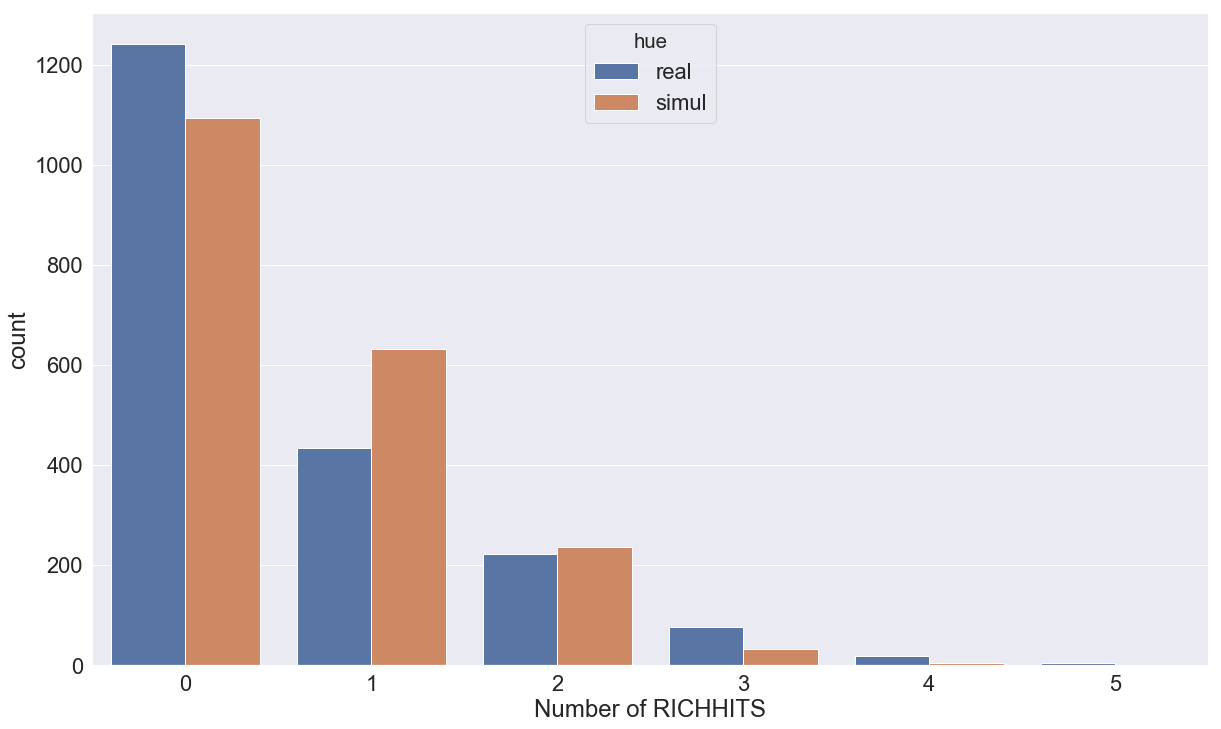

In [16]:
# 비교를 위해 실제, 가상 결과를 담을 DataFrame을 생성

pl_df_rich = pd.DataFrame(columns=['rich_count', 'hue'])
pl_df_rich['rich_count'] = pl_real_rich_count + pl_simul_rich_count
pl_df_rich['hue'] = ['real'] * 2000 + ['simul'] * 2000

# 실제, 가상의 각 게임당 RICHHITS 갯수 시각화

plt.figure(figsize=(20,12))
sns.countplot(x='rich_count', data=pl_df_rich, hue='hue')
plt.xlabel("Number of RICHHITS")
plt.show()

시각화 결과 시뮬레이션 데이터와 실제 데이터 사이에 어느정도 차이가 있는 것처럼 보인다는 것을 알 수 있습니다. 이 차이가 유의한지 여부를 확인하기 위해 카이제곱 적합도 검정을 사용합니다. 카이제곱 적합도 검정은 범주형 확률분포의 모수 $\mu=(\mu_1, \ldots, \mu_K)$에 대한 가설을 조사하는 검정 방법입니다. 원래 범주형 값 $k$가 나와야 할 횟수의 기댓값 $m_k$와 실제 나온 횟수 $x_k$의 차이를 이용하여 다음처럼 검정통계량을 구합니다.

$$
\begin{align}
\sum_{k=1}^K \dfrac{(x_k - m_k)^2}{m_k}
\end{align}
$$

###### Hypothesis test 1

귀무 가설과 대립 가설은 아래와 같습니다.

* H<sub>0</sub>: 시뮬레이션 결과는 실제 결과와 같다
* H<sub>1</sub>: 시뮬레이션 결과는 실제 결과와 다르다

테스트는 5% 유의 수준에서 수행되었습니다.

In [17]:
length = min(len(pd.Series(pl_real_rich_count).value_counts()), len(pd.Series(pl_simul_rich_count).value_counts()))

f_obs = list(pd.Series(pl_real_rich_count).value_counts())[:length]
f_exp = list(pd.Series(pl_simul_rich_count).value_counts())[:length]

st.chisquare(f_obs, f_exp=f_exp)

Power_divergenceResult(statistic=198.21552768935283, pvalue=9.088931052345755e-42)

p-value가 1.3912538539206486e-32로 유의수준 0.05보다 매우 작은 값이므로 기무가설을 기각하고 대립가설을 지지합니다.

---

## 3-2. 비교 - 각 reel 마다 같은 symbol이 나오는 빈도 비교

각 reel은 3개의 칸으로 구성되어 있기 때문에  

1번 유형   | ●●● (모두 같음)  
2-1번 유형 | ●●○ (3번째만 다르고 나머지는 같음)  
2-2번 유형 | ●○● (2번째만 다르고 나머지는 같음)  
2-3번 유형 | ○●● (1번째만 다르고 나머지는 같음)  
3번 유형   | ●○⊙ (모두 다름)

다음과 같이 symbol이 겹치는 수에 따라 5개의 유형으로 구분지을 수 있습니다.

In [18]:
def getReelInfo(df, reel):
    row_type = []
    reel_symbols = []
    r_list = []
    s = ''
    for n, row in enumerate(df[df['col'] == reel]['classname']):
        r_list.append(row)
        s += row
        if not (n + 1) % 3:
            if r_list[0] == r_list [1] and r_list[1] == r_list[2]:
                row_type.append('1')
            elif r_list[0] == r_list[1] and r_list[0] != r_list[2] and r_list[1] != r_list[2]:
                row_type.append('2-1')
            elif r_list[0] == r_list[2] and r_list[0] != r_list[1] and r_list[2] != r_list[1]:
                row_type.append('2-2')
            elif r_list[1] == r_list[2] and r_list[1] != r_list[0] and r_list[2] != r_list[0]:
                row_type.append('2-3')
            else:
                row_type.append('3')
            r_list = []
            reel_symbols.append(s)
            s= ''
    return row_type, reel_symbols

In [49]:
# 실제 게임의 각 reel의 유형, symbol 저장

pl_real_reel1_rtype, pl_real_reel1_rsymbols = getReelInfo(pl_slot_result, 1)
pl_real_reel2_rtype, pl_real_reel2_rsymbols = getReelInfo(pl_slot_result, 2)
pl_real_reel3_rtype, pl_real_reel3_rsymbols = getReelInfo(pl_slot_result, 3)
pl_real_reel4_rtype, pl_real_reel4_rsymbols = getReelInfo(pl_slot_result, 4)
pl_real_reel5_rtype, pl_real_reel5_rsymbols = getReelInfo(pl_slot_result, 5)

pl_real_reel_rtype = pl_real_reel1_rtype + pl_real_reel2_rtype + pl_real_reel3_rtype+ pl_real_reel4_rtype + pl_real_reel5_rtype 


# 가상 게임의 각 reel의 유형, symbol 저장

pl_simul_reel1_rtype, pl_simul_reel1_rsymbols = getReelInfo(pl_simul_result, 1)
pl_simul_reel2_rtype, pl_simul_reel2_rsymbols = getReelInfo(pl_simul_result, 2)
pl_simul_reel3_rtype, pl_simul_reel3_rsymbols = getReelInfo(pl_simul_result, 3)
pl_simul_reel4_rtype, pl_simul_reel4_rsymbols = getReelInfo(pl_simul_result, 4)
pl_simul_reel5_rtype, pl_simul_reel5_rsymbols = getReelInfo(pl_simul_result, 5)

pl_simul_reel_rtype = pl_simul_reel1_rtype + pl_simul_reel2_rtype + pl_simul_reel3_rtype + pl_simul_reel4_rtype + pl_simul_reel5_rtype


# 비교를 위해 실제 게임 데이터의 reel_type을 담을 DataFrame을 생성

df_pl_rtype = pd.DataFrame(columns=['reel_type', 'reel_num', 'game_type'])
df_pl_rtype['reel_type'] = pl_real_reel_rtype + pl_simul_reel_rtype
df_pl_rtype['reel_num'] = (['reel_1'] * 2000 + ['reel_2'] * 2000 + ['reel_3'] * 2000 + ['reel_4'] * 2000 + ['reel_5'] * 2000) * 2
df_pl_rtype['game_type'] = ['real'] * 10000 + ['simul'] * 10000

df_pl_rtype.head()

,reel_type,reel_num,game_type
0,3,reel_1,real
1,3,reel_1,real
2,1,reel_1,real
3,3,reel_1,real
4,3,reel_1,real


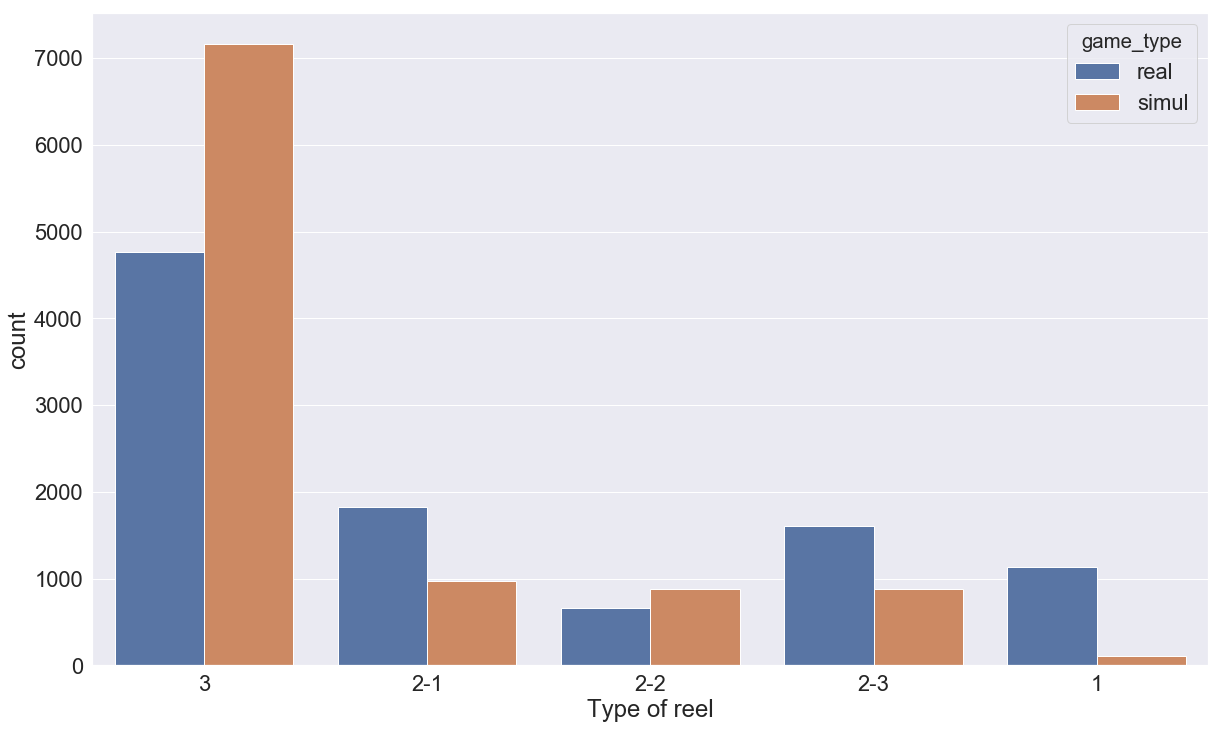

In [50]:
# 모든 reel의 reel_type 시각화

plt.figure(figsize=(20,12))
sns.countplot(x='reel_type', data=df_pl_rtype, order=['3', '2-1', '2-2', '2-3', '1'], hue='game_type')
plt.xlabel("Type of reel")
plt.show()

시각화 결과 시뮬레이션 결과와 실제 결과 사이에 큰 차이가 있음을 알 수 있습니다. 시뮬레이션의 모델처럼 모든 칸이 독립적이고 설정된 확률대로 Symbol이 등장하게 되면 한 개의 reel에서 3개가 모두 다를 확률(reel_type == 3)은 크고 (약 70%) 모두 같을 확률(reel_type == 1)은 매우 적지만 (약 1%) 실제 게임 결과에서는 3개가 모두 다를 확률은 시뮬레이션 결과보다 더 작고 모두 같을 확률은 훨씬 큰 것으로 나타납니다.

또한 2개가 같고 1개는 다른 유형(Type of reel 2-1, 2-2, 2-3)에서도 확률이 서로 같지 않고 다른 것을 확인할 수 있습니다.

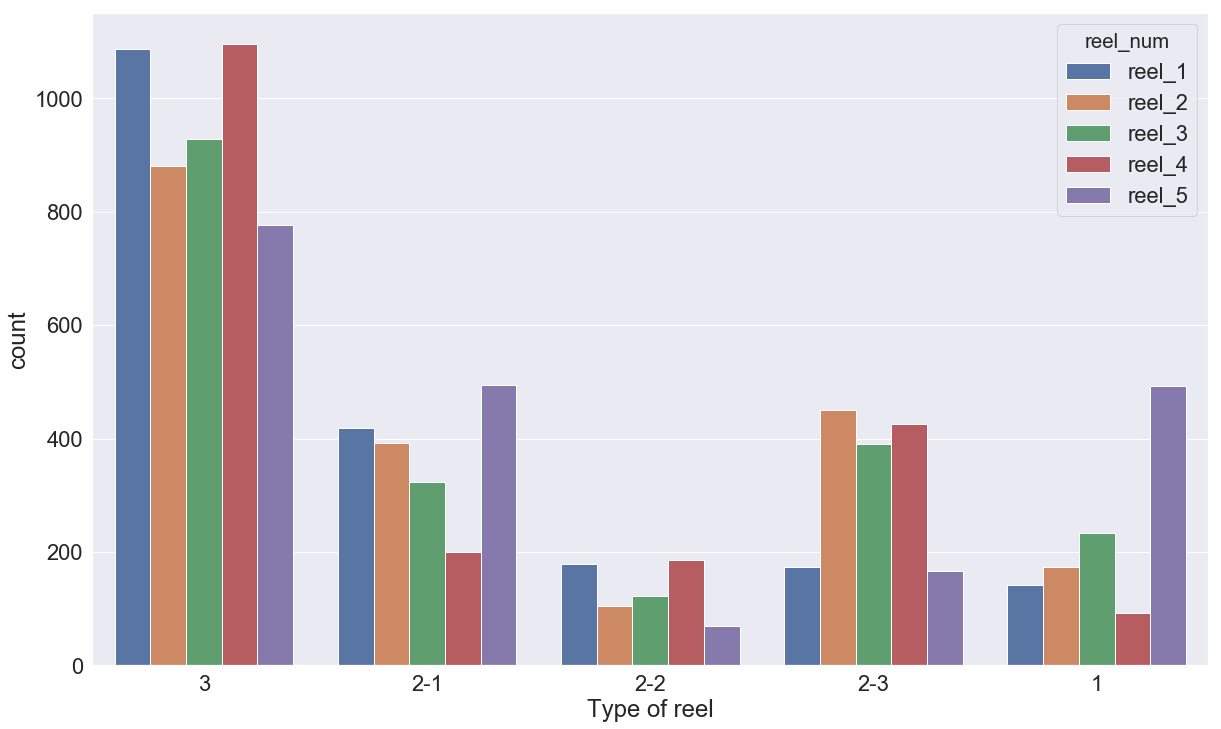

In [51]:
# 각 reel_num 별 reel_type 시각화

plt.figure(figsize=(20,12))
sns.countplot(x='reel_type', data=df_pl_rtype[df_pl_rtype['game_type']=='real'], hue='reel_num', order=['3', '2-1', '2-2', '2-3', '1'])
plt.xlabel("Type of reel")
plt.show()

5개의 reel 별로 시각화를 한 결과 reel에 따라서도 각 유형의 확률이 다른 것을 알 수 있습니다.

따라서 게임의 모델을 보완할 때 각 reel_type의 출현 확률, 각 reel별 확률을 고려할 필요가 있음을 알 수 있습니다.

---

## 3.3 비교 - 한 번의 spin마다 등장하는 symbol의 개수 비교

In [52]:
# 실제 게임의 게임당 unique symbol의 개수를 담은 list를 생성

pl_real_unique_count = []

for i in range(2000):
    pl_real_unique_count.append(len(set(pl_slot_result_per_game[i])))


# 가상 게임의 게임당 unique symbol의 개수를 담은 list를 생성

pl_simul_unique_count = []

for i in range(2000):
    pl_simul_unique_count.append(len(set(pl_simul_result_per_game[i])))


# 실제 게임 데이터와 가상 게임 데이터 병합
df_pl_real_simul = pd.DataFrame(columns=['classname', 'game_type'])
df_pl_real_simul['classname'] = pd.concat([pl_slot_result['classname'], pl_simul_result['classname']])
df_pl_real_simul['game_type'] = ['real'] * len(pl_slot_result['classname']) + ['simul'] * len(pl_simul_result['classname'])
df_pl_real_simul = df_pl_real_simul.reset_index(drop=True)


# 비교를 위해 unique symbol의 실제, 가상 결과를 담을 DataFrame을 생성

df_pl_unique_count = pd.DataFrame(columns=['unique_count', 'game_type'])
df_pl_unique_count['unique_count'] = pl_real_unique_count + pl_simul_unique_count
df_pl_unique_count['game_type'] = ['real'] * len(pl_real_unique_count) + ['simul'] * len(pl_simul_unique_count)

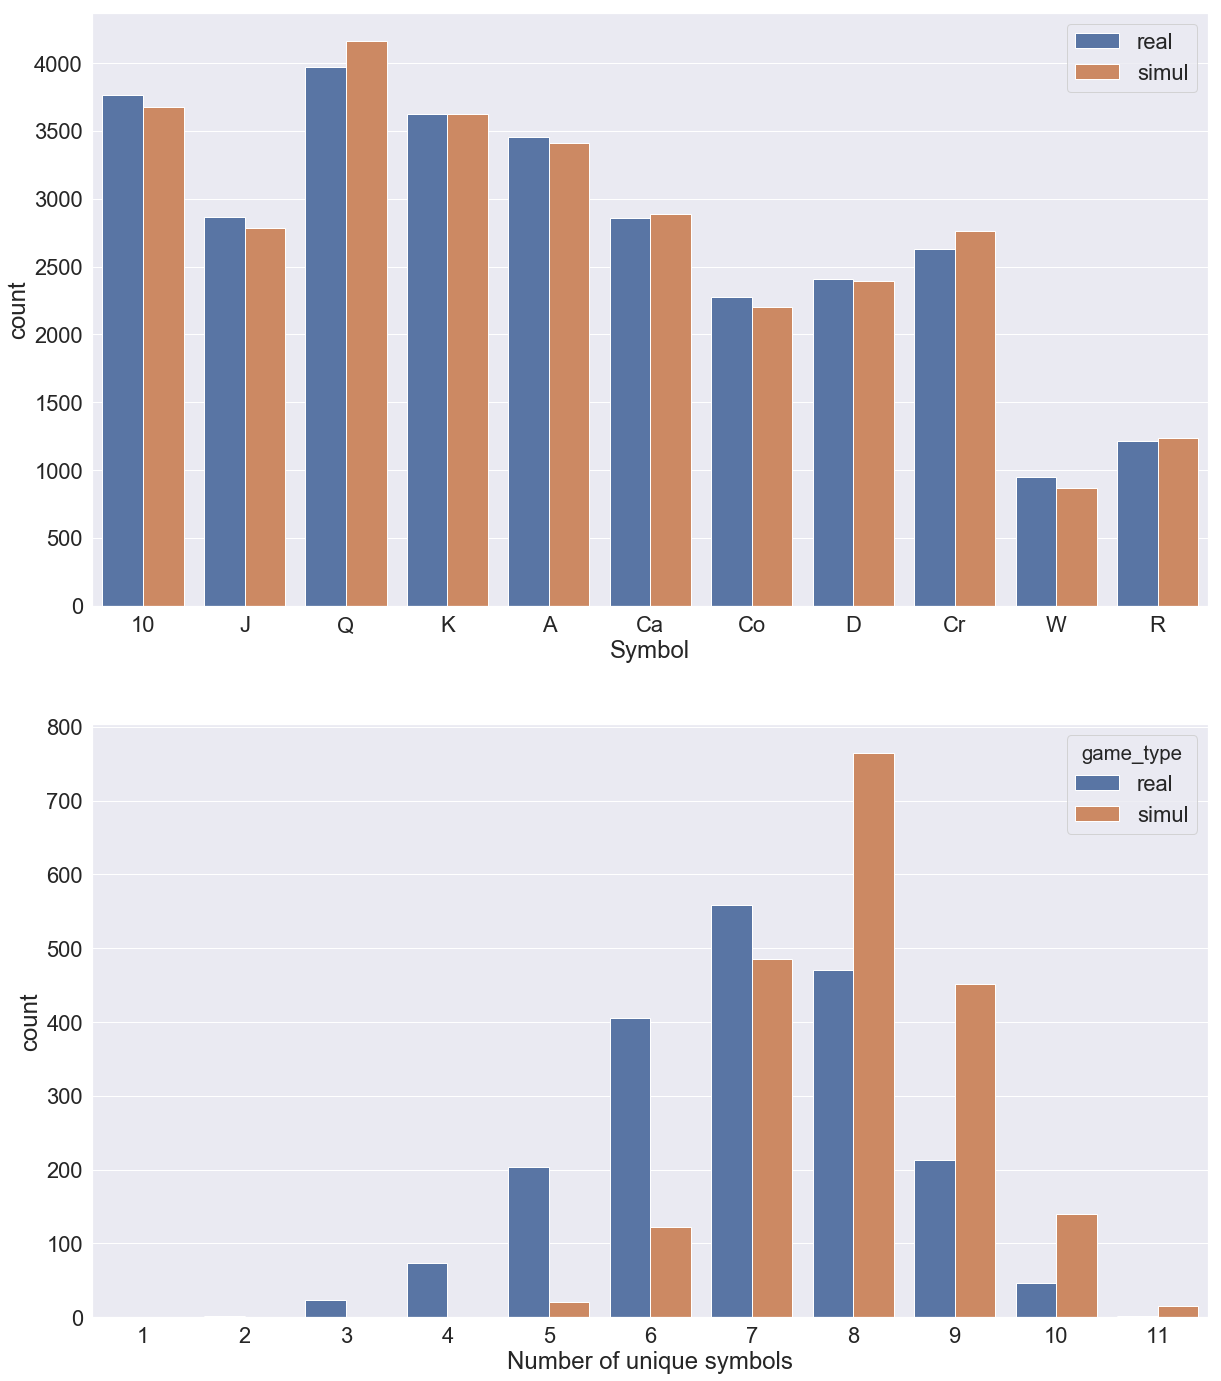

In [53]:
plt.figure(figsize=(20,24))
plt.subplot(2,1,1)
sns.countplot(x='classname', data=df_pl_real_simul, hue='game_type', order=pl_labels)
plt.xlabel('Symbol')

plt.legend()
plt.subplot(2,1,2)
sns.countplot(x='unique_count', data=df_pl_unique_count, hue='game_type')
plt.xlabel('Number of unique symbols')
plt.show()

우선 각 게임의 고유한 Symbol 개수를 알아보기 전에, 실제 게임 데이터의 Symbol별 등장 확률과 가상 게임 데이터의 등장 확률이 같은 지를 확인해보겠습니다. 이 차이가 유의한지 여부를 확인하기 위해 카이제곱 적합도 검정을 사용합니다.

###### Hypothesis test 3

귀무 가설과 대립 가설은 아래와 같습니다.

* H<sub>0</sub>: 시뮬레이션 결과는 실제 결과와 같다
* H<sub>1</sub>: 시뮬레이션 결과는 실제 결과와 다르다

테스트는 5% 유의 수준에서 수행되었습니다.

In [32]:
f_obs = list(pl_slot_result['classname'].value_counts().sort_index())
f_exp = list(pl_simul_result['classname'].value_counts().sort_index())

st.chisquare(f_obs, f_exp=f_exp)

Power_divergenceResult(statistic=17.38832309245989, pvalue=0.06620098789980232)

p-value가 ??로 유의수준 0.05보다 큰 값이므로 귀무가설을 지지합니다. 이처럼 실제 결과와 시뮬레이션 결과의 Symbol 등장 횟수는 차이가 없다고 볼 수 있지만 두번째 시각화 그래프를 보면 가상 게임 데이터는 실제 게임 데이터에 비해 오른쪽으로 치우쳐있는 것을 볼 수 있습니다.
즉 위의 2개의 그래프는 실제 게임에서는 시뮬레이션 게임에 비에서 Symbol이 같은 것끼리 몰아서 나오는 경향을 가지고 있다는 것을 의미합니다.

---

## 3-4 비교 - 획득한 reward 금액과 payline의 길이(x3, x4, x5) 비교

In [54]:
# 비교에 필요한 함수 생성

pl_paytable = pd.read_csv('../data/slot_machine/platinum_csv/pl_paytable.csv')
paylines = [[1, 4, 7, 10, 13],
             [0, 3, 6, 9, 12],
             [2, 5, 8, 11, 14],
             [0, 4, 8, 10, 12],
             [2, 4, 6, 10, 14],
             [0, 3, 7, 11, 14],
             [2, 5, 7, 9, 12],
             [1, 5, 8, 11, 13],
             [1, 3, 6, 9, 13],
             [0, 4, 7, 10, 12],
             [2, 4, 7, 10, 14],
             [0, 4, 6, 10, 12],
             [2, 4, 8, 10, 14],
             [1, 4, 6, 10, 13],
             [1, 4, 8, 10, 13],
             [1, 5, 7, 9, 13],
             [1, 3, 7, 11, 13],
             [0, 5, 6, 11, 12],
             [2, 3, 8, 9, 14],
             [1, 3, 8, 9, 13],
             [1, 5, 6, 11, 13],
             [0, 3, 8, 9, 12],
             [2, 5, 6, 11, 14],
             [0, 5, 8, 11, 12],
             [2, 3, 6, 9, 14],
             [0, 3, 7, 9, 12],
             [2, 5, 7, 11, 14],
             [0, 4, 8, 11, 14],
             [2, 4, 6, 9, 12],
             [1, 3, 7, 9, 13]]

def getSym(lst):
    if len(set(lst)) < 2:
        return lst[0]
    else:
        for x in list(set(lst)):
            if x != 'W':
                return x
            else:
                continue

def richCheck(game, bpl):
    rnum = game.count('R')
    if rnum <= 2:
        return 0
    elif rnum == 3:
        return bpl * 30
    elif rnum == 4:
        return bpl * 90
    elif rnum == 5:
        return bpl * 240
    elif rnum == 6:
        return bpl * 900
    elif rnum == 7:
        return bpl * 2250
    elif rnum == 8:
        return bpl * 15000
    elif rnum == 9:
        return bpl * 30000

def calPlatinumPayline(game, bpl):
    pay = 0
    r_acc = 0
    pay_type_list = []
    payline_num = []
    
    # RICH 보너스 계산
    pay += richCheck(game, bpl)
    r_acc += game.count('R')
    
    # payline 계산
    for n, payline in enumerate(paylines):
        tmp = []
        for i in range(5):
            if i == 4:
                tmp.append(game[payline[i]])
                break
            if i == 0 and game[payline[i]] == 'W':
                tmp.append(game[payline[i]])
            elif game[payline[i]] != game[payline[i+1]] and game[payline[i+1]] != 'W':
                tmp.append(game[payline[i]])
                break
            else:
                tmp.append(game[payline[i]])

        if len(tmp) >= 3:
            sym = getSym(tmp)
            pay += pl_paytable.loc[len(tmp)-3, sym] * bpl
            pay_type_list.append(tmp)
            payline_num.append(n)
    
    return pay, pay_type_list, payline_num

Platinum Real game hit probability :  38.55
Platinum Real Average Reward :  34503.0 

Platinum Simulation game hit probability :  29.15
Platinum Simulation Average Reward :  7438.0


"\n# 각 payline별 당첨 횟수 시각화\nax = plt.subplot(gs[1, :])\nsns.countplot(x='payline_num', data=df_pl_all_payline[df_pl_all_payline['game_type']=='real'], palette='GnBu_d')\n\nax = plt.subplot(gs[2, :])\nsns.countplot(x='payline_num', data=df_pl_all_payline[df_pl_all_payline['game_type']=='simul'], palette='GnBu_d')\nplt.show()\n"

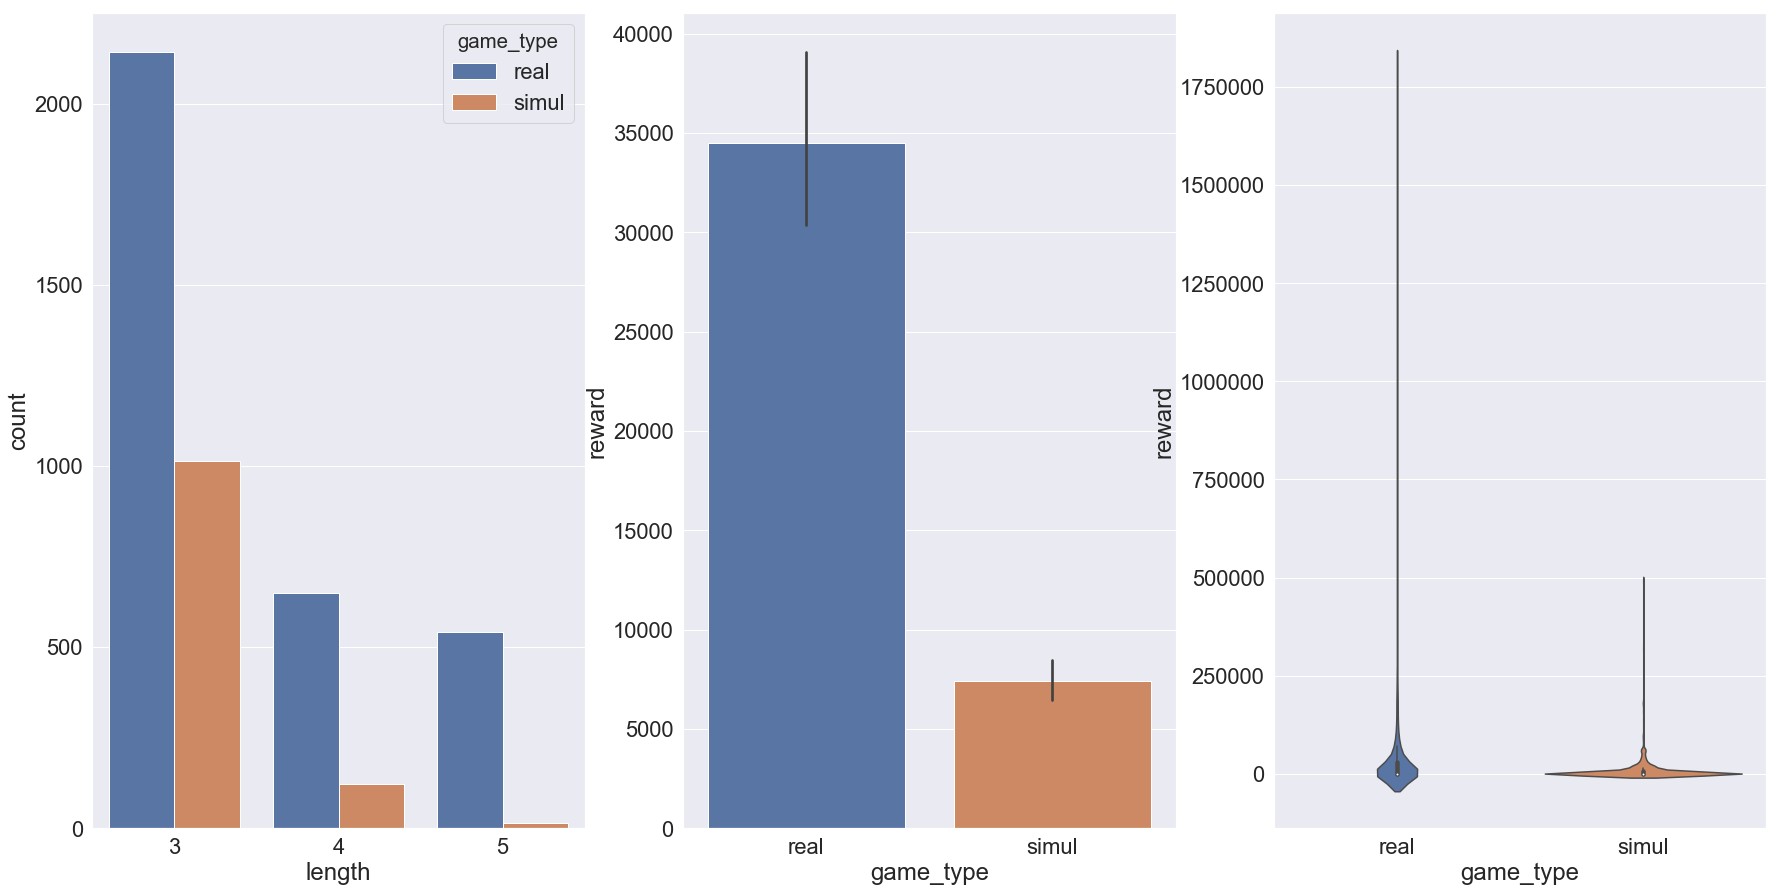

In [66]:
# 게임당 당첨 금액과 당첨된 Symbol의 종류를 담을 list 생성

pl_real_pay_list, pl_real_pay_type_list, pl_real_payline_num = [], [], []
pl_simul_pay_list, pl_simul_pay_type_list, pl_simul_payline_num = [], [], []

for real_game in pl_slot_result_per_game:
    pl_real_pay_list.append(calPlatinumPayline(real_game, 2000)[0])
    pl_real_pay_type_list.extend(calPlatinumPayline(real_game, 2000)[1])
    pl_real_payline_num.extend(calPlatinumPayline(real_game, 2000)[2])

for simul_game in pl_simul_result_per_game:
    pl_simul_pay_list.append(calPlatinumPayline(simul_game, 2000)[0])
    pl_simul_pay_type_list.extend(calPlatinumPayline(simul_game, 2000)[1])
    pl_simul_payline_num.extend(calPlatinumPayline(simul_game, 2000)[2])


# 당첨된 payline의 length를 담을 list 생성

pl_real_payline_length = [len(pay_type) for pay_type in pl_real_pay_type_list]
pl_simul_payline_length = [len(pay_type) for pay_type in pl_simul_pay_type_list]


# 시각화를 위한 DataFrame 생성

df_pl_pay_list = pd.DataFrame(columns=['reward', 'game_type'])
df_pl_pay_list['reward'] = pl_real_pay_list + pl_simul_pay_list
df_pl_pay_list['game_type'] = ['real'] * 2000 + ['simul']*2000


df_pl_payline_length = pd.DataFrame(columns=['length', 'game_type'])
df_pl_payline_length['length'] = pl_real_payline_length + pl_simul_payline_length
df_pl_payline_length['game_type'] = ['real'] * len(pl_real_payline_length) + ['simul'] * len(pl_simul_payline_length)

df_pl_all_payline = pd.DataFrame(columns=['payline_num', 'game_type'])
df_pl_all_payline['payline_num'] = pl_real_payline_num + pl_simul_payline_num
df_pl_all_payline['game_type'] = ['real'] * len(pl_real_payline_num) + ['simul'] * len(pl_simul_payline_num)


# 게임 유형별 hit probability, average reward 출력

print('Platinum Real game hit probability : ', round(len([pay for pay in pl_real_pay_list if not pay == 0])/len(pl_real_pay_list)*100,2))
print('Platinum Real Average Reward : ', sum(pl_real_pay_list) / len(pl_real_pay_list),'\n')

print('Platinum Simulation game hit probability : ', round(len([pay for pay in pl_simul_pay_list if not pay == 0])/len(pl_simul_pay_list)*100,2))
print('Platinum Simulation Average Reward : ', sum(pl_simul_pay_list) / len(pl_simul_pay_list))



## 시각화 ##


# 3 x 2 sub plots 생성
gs = gridspec.GridSpec(1, 3)
plt.figure(figsize=(30,15))

# 게임 유형별 reward 빈도 시각화
ax = plt.subplot(gs[0, 0])
sns.countplot(x='length', data=df_pl_payline_length, hue='game_type')


# 게임 유형별 average reward 시각화
ax = plt.subplot(gs[0, 1])
sns.barplot(x='game_type', y='reward', data=df_pl_pay_list)


# payline length 시각화
ax = plt.subplot(gs[0, 2])
sns.violinplot(x='game_type', y='reward', data=df_pl_pay_list)


"""
# 각 payline별 당첨 횟수 시각화
ax = plt.subplot(gs[1, :])
sns.countplot(x='payline_num', data=df_pl_all_payline[df_pl_all_payline['game_type']=='real'], palette='GnBu_d')

ax = plt.subplot(gs[2, :])
sns.countplot(x='payline_num', data=df_pl_all_payline[df_pl_all_payline['game_type']=='simul'], palette='GnBu_d')
plt.show()
"""

우선 **첫번째 그래프**를 보면 reward를 획득한 payline의 길이(x3, x4, x5)에서 큰 차이를 보입니다. 이는 위의 시각화에서 보았듯이, Simulation 게임에서 한 게임에서 등장하는 같은 symbol의 수가 실제 게임에 비해 적기 때문에 당첨된 payline의 수가 적어져서 위와 같은 결과를 나타내는 것으로 보입니다. 또 주목해야 할 것은 x4의 count와 x5의 count의 차이가 그다지 크지 않은 것을 알 수 있습니다.

**두번째 그래프**를 보면, 첫번째 그래프에서 보았듯이 당첨된 payline의 수가 적어서 보너스 게임을 제외한 RTP가 실제 게임(약 57.5%)에 비해 시뮬레이션 게임(약 12.4%)이 크게 떨어지는 것을 알 수 있습니다.

**세번째 그래프**를 보면 큰 금액을 주는 x4, x5 payline의 수가 상대적으로 적어서 실제 데이터가 위로 긴 꼬리를 가지고 있는 반면 시뮬레이션 데이터는 짧은 꼬리를 가지고 있습니다.

# Monster

In [452]:
# csv 파일 불러오기

ms_slot_result = pd.read_csv('../data/slot_machine/monster_csv/ms_all.csv')
ms_slot_result.head()

,img,classname
0,monster_0_0.jpg,OM
1,monster_0_1.jpg,W
2,monster_0_2.jpg,A
3,monster_0_3.jpg,A
4,monster_0_4.jpg,Q


In [454]:
len(ms_slot_result)

30000

In [455]:
ms_labels = ['10', 'J', 'Q', 'K', 'A', 'GGM', 'OM', 'RM', 'GWM', 'W', 'S']

In [456]:
# 각 칸의 결과마다 game, row, col column 생성

ms_slot_result_game = [int(i_name.split('_')[1]) for n, i_name in enumerate(ms_slot_result['img'])]
ms_slot_result_row = [int(i_name.split('_')[2].split('.')[0]) % 3 + 1 for n, i_name in enumerate(ms_slot_result['img'])]
ms_slot_result_col = [int(i_name.split('_')[2].split('.')[0]) // 3 + 1 for n, i_name in enumerate(ms_slot_result['img'])]

In [457]:
ms_slot_result['game'] = ms_slot_result_game
ms_slot_result['row'] = ms_slot_result_row
ms_slot_result['col'] = ms_slot_result_col

ms_slot_result.head(15)

,img,classname,game,row,col
0,monster_0_0.jpg,OM,0,1,1
1,monster_0_1.jpg,W,0,2,1
2,monster_0_2.jpg,A,0,3,1
3,monster_0_3.jpg,A,0,1,2
4,monster_0_4.jpg,Q,0,2,2
5,monster_0_5.jpg,GWM,0,3,2
6,monster_0_6.jpg,OM,0,1,3
7,monster_0_7.jpg,10,0,2,3
8,monster_0_8.jpg,J,0,3,3
9,monster_0_9.jpg,GGM,0,1,4


In [458]:
tmp = []
ms_slot_result_per_game = []
for n, x in enumerate(ms_slot_result['classname']):
    tmp.append(x)
    if (n+1) % 15 == 0:
        ms_slot_result_per_game.append(tmp)
        tmp = []

In [459]:
# 각 Symbol의 출현 확률의 구체적인 수치

ms_slot_result['classname'].value_counts() / len(ms_slot_result) * 100

Q      14.126667
K      13.960000
10     13.136667
A      12.740000
J      12.003333
GGM     9.553333
OM      7.376667
RM      6.440000
S       4.786667
GWM     4.393333
W       1.483333
Name: classname, dtype: float64

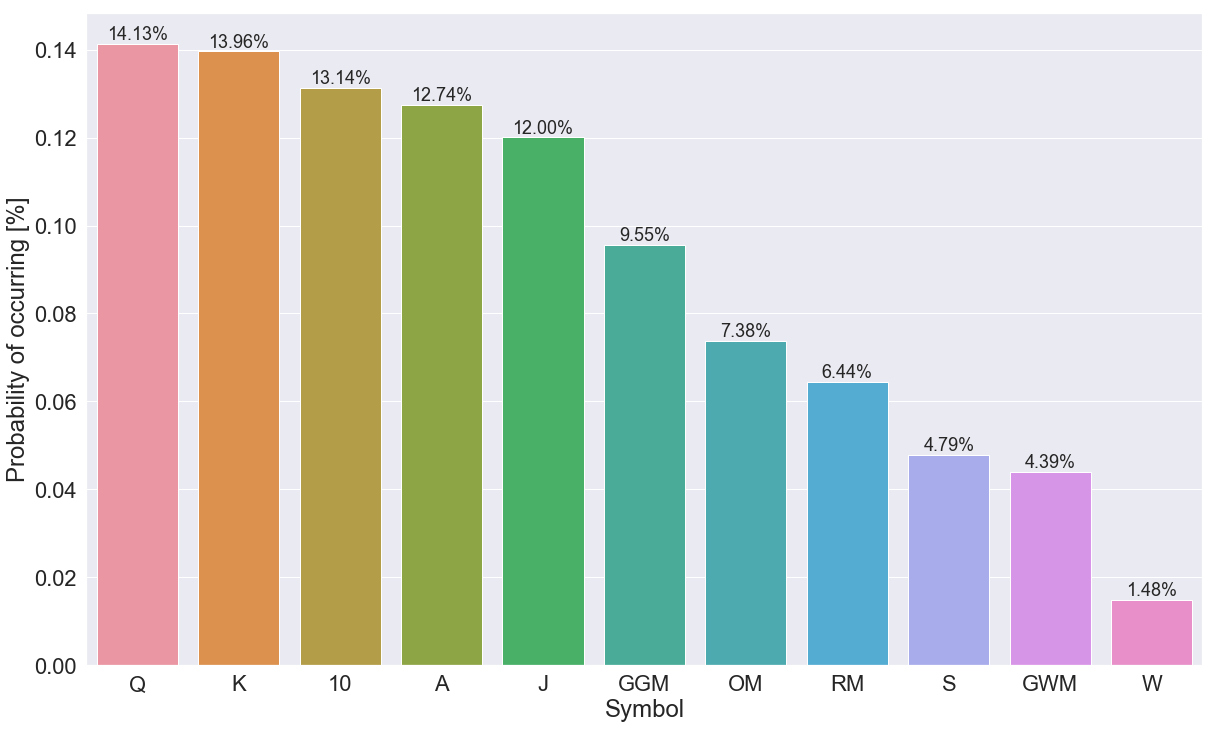

In [460]:
# 각 Symbol의 출현 확률 시각화

plt.figure(figsize=(20,12))
ax = sns.barplot(x=ms_slot_result['classname'].value_counts().index, y=ms_slot_result['classname'].value_counts() / len(ms_slot_result))
plt.xlabel("Symbol")
plt.ylabel("Probability of occurring [%]")


for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.2f}%'.format(y*100), (x.mean(), y), ha='center', va='bottom', fontsize=18) # set the alignment of the text

plt.show()

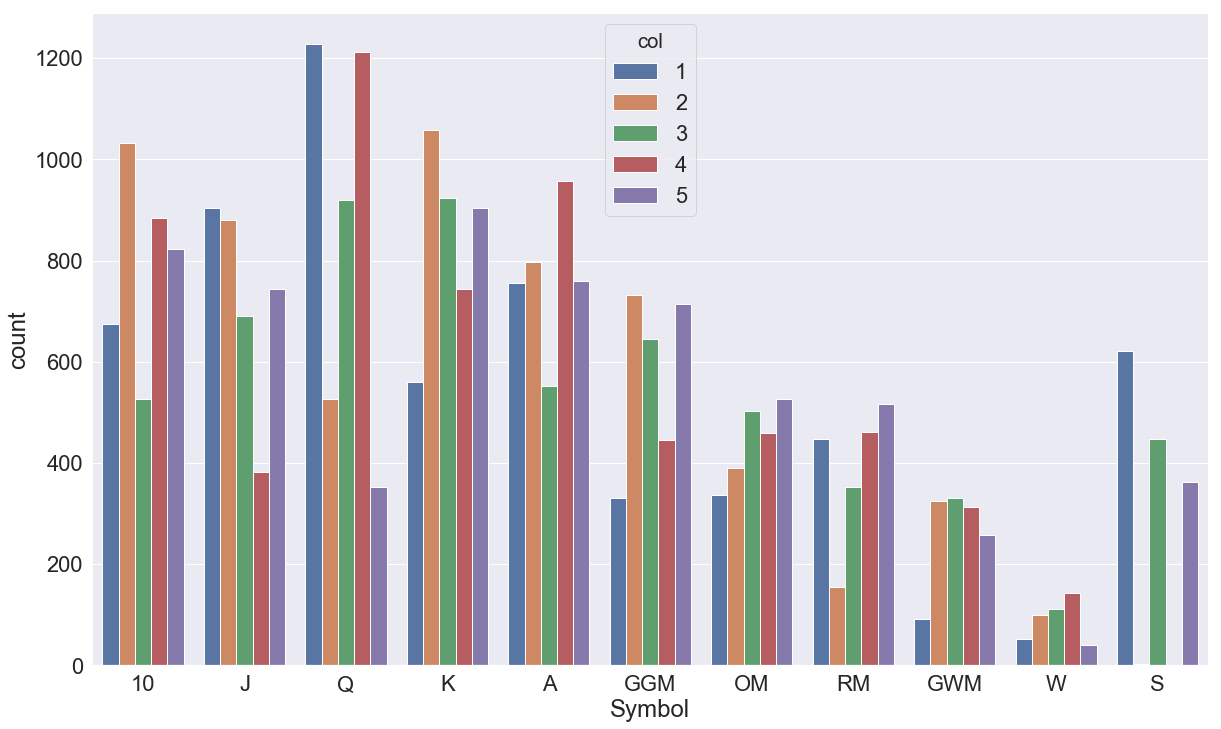

In [461]:
# 각 reel별 출현 횟수 시각화

plt.figure(figsize=(20,12))
sns.countplot(x='classname', data=ms_slot_result, hue='col', order=ms_labels)
plt.xlabel("Symbol")
plt.show()

In [462]:
df_tmp = ms_slot_result[ms_slot_result['classname'] == 'S']

In [465]:
ms_slot_result[ms_slot_result['classname'] == 'S']['col'].value_counts()

1    622
3    448
5    363
2      3
Name: col, dtype: int64

In [464]:
df_tmp[df_tmp['col'] == 2]

,img,classname,game,row,col
19309,monster_1287_4.jpg,S,1287,2,2
25069,monster_1671_4.jpg,S,1671,2,2
29134,monster_1942_4.jpg,S,1942,2,2


In [389]:
'''
# Baseline Model

Monster Slot 2000번의 실제 게임 데이터를 기반으로 각 Symbol의 출현 빈도 설정 (근사치)

# Q   : 14 %
# K   : 14 %
# 10  : 13 %
# A   : 12.5 %
# J   : 12 %
# GGM : 9.5 %
# OM  : 7.5 %
# RM  : 6.5 %
# S   : 5 %
# GWM : 4.5 %
# W   : 1.5 %
'''

# numpy의 randint를 통해 출현 확률을 기반으로 Symbol을 Return하는 함수

def getMonsterSymbol(start, end):
    i = np.random.randint(start, end)
    if i <= 28:
        return 'Q'
    elif i <= 56 and i > 28:
        return 'K'
    elif i <= 82 and i > 56:
        return '10'
    elif i <= 107 and i > 82:
        return 'A'
    elif i <= 131 and i > 107:
        return 'J'
    elif i <= 150 and i > 131:
        return 'GGM'
    elif i <= 165 and i > 150:
        return 'OM'
    elif i <= 178 and i > 165:
        return 'RM'
    elif i <= 187 and i > 178:
        return 'GWM'
    elif i <= 190 and i > 187:
        return 'W'
    elif i > 190:
        return 'S'

# 1회의 Spin 실행을 구현한 함수

def spin_monster():
    game = []
    start = 1
    
    for i in range(15):
        # 각 15개의 칸에 Symbol 추가
        if i%6 <= 2 and game.count('S') < ((i//6) + 1):
            end = 201
            game.append(getMonsterSymbol(start, end))
        else:
            end = 191
            game.append(getMonsterSymbol(start, end))

    return game

In [390]:
# 실행 결과를 담을 list
ms_simul_result_per_game = []

# 2000번의 게임을 실행
for i in range(2000):
    ms_simul_result_per_game.append(spin_monster())

In [391]:
# 실제 게임 플레이 DataFrame을 불러와서 가상 게임플레이 데이터로 변경

ms_simul_result = ms_slot_result[['classname', 'game', 'row', 'col']]

ms_simul_classname = []

for game in ms_simul_result_per_game:
    for x in game:
        ms_simul_classname.append(x)

ms_simul_result['classname'] = ms_simul_classname

C:\Users\Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [392]:
ms_simul_result.head()

,classname,game,row,col
0,Q,0,1,1
1,J,0,2,1
2,K,0,3,1
3,Q,0,1,2
4,K,0,2,2


## 비교 - Scatter

In [431]:
# 실제 게임의 게임당 SCATTER 출현 횟수를 담은 list를 생성

ms_real_scatter_count =  []
for game in ms_slot_result_per_game:
    ms_real_scatter_count.append(game.count('S'))

# 실제 게임의 Spin당 RICHHITS의 출현 갯수

pd.Series(ms_real_scatter_count).value_counts() / 2000

0    0.4325
1    0.4310
2    0.1225
3    0.0140
dtype: float64

In [394]:
# 가상 게임의 게임당 SCATTER 출현 횟수를 담은 list를 생성

ms_simul_scatter_count = []
for game in ms_simul_result_per_game:
    ms_simul_scatter_count.append(game.count('S'))

# 가상 게임의 Spin당 RICHHITS의 출현 갯수

pd.Series(ms_simul_scatter_count).value_counts()

0    1275
1     584
2     126
3      15
dtype: int64

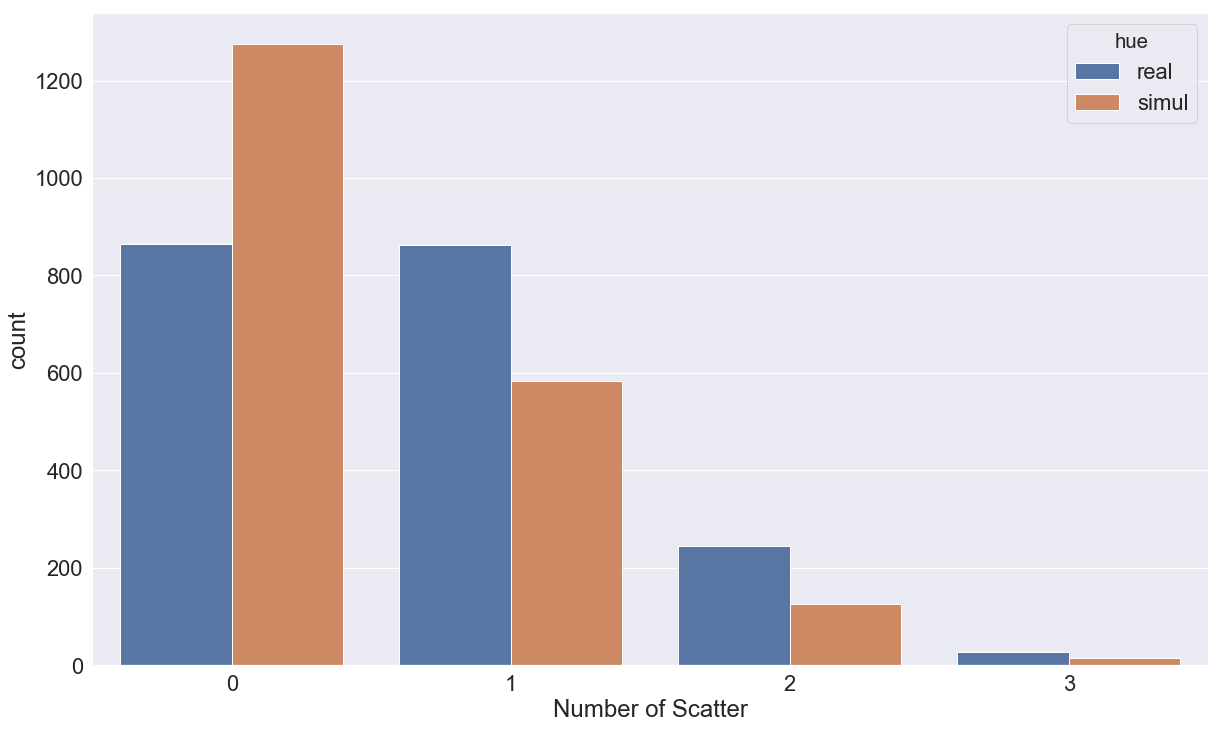

In [395]:
# 비교를 위해 실제, 가상 결과를 담을 DataFrame을 생성

df_ms_scatter = pd.DataFrame(columns=['scatter_count', 'hue'])
df_ms_scatter['scatter_count'] = ms_real_scatter_count + ms_simul_scatter_count
df_ms_scatter['hue'] = ['real'] * 2000 + ['simul'] * 2000

# 실제, 가상의 각 게임당 RICHHITS 갯수 시각화

plt.figure(figsize=(20,12))
sns.countplot(x='scatter_count', data=df_ms_scatter, hue='hue')
plt.xlabel("Number of Scatter")
plt.show()

## 비교 - ReelType

In [396]:
def getReelInfo(df, reel):
    row_type = []
    reel_symbols = []
    r_list = []
    s = ''
    for n, row in enumerate(df[df['col'] == reel]['classname']):
        r_list.append(row)
        s += row
        if not (n + 1) % 3:
            if r_list[0] == r_list [1] and r_list[1] == r_list[2]:
                row_type.append('1')
            elif r_list[0] == r_list[1] and r_list[0] != r_list[2] and r_list[1] != r_list[2]:
                row_type.append('2-1')
            elif r_list[0] == r_list[2] and r_list[0] != r_list[1] and r_list[2] != r_list[1]:
                row_type.append('2-2')
            elif r_list[1] == r_list[2] and r_list[1] != r_list[0] and r_list[2] != r_list[0]:
                row_type.append('2-3')
            else:
                row_type.append('3')
            r_list = []
            reel_symbols.append(s)
            s= ''
    return row_type, reel_symbols

In [397]:
# 실제 게임의 각 reel의 유형, symbol 저장

ms_real_reel1_rtype, ms_real_reel1_rsymbols = getReelInfo(ms_slot_result, 1)
ms_real_reel2_rtype, ms_real_reel2_rsymbols = getReelInfo(ms_slot_result, 2)
ms_real_reel3_rtype, ms_real_reel3_rsymbols = getReelInfo(ms_slot_result, 3)
ms_real_reel4_rtype, ms_real_reel4_rsymbols = getReelInfo(ms_slot_result, 4)
ms_real_reel5_rtype, ms_real_reel5_rsymbols = getReelInfo(ms_slot_result, 5)

ms_real_reel_rtype = ms_real_reel1_rtype + ms_real_reel2_rtype + ms_real_reel3_rtype + ms_real_reel4_rtype + ms_real_reel5_rtype 

In [398]:
# 가상 게임의 각 reel의 유형, symbol 저장

ms_simul_reel1_rtype, ms_simul_reel1_rsymbols = getReelInfo(ms_simul_result, 1)
ms_simul_reel2_rtype, ms_simul_reel2_rsymbols = getReelInfo(ms_simul_result, 2)
ms_simul_reel3_rtype, ms_simul_reel3_rsymbols = getReelInfo(ms_simul_result, 3)
ms_simul_reel4_rtype, ms_simul_reel4_rsymbols = getReelInfo(ms_simul_result, 4)
ms_simul_reel5_rtype, ms_simul_reel5_rsymbols = getReelInfo(ms_simul_result, 5)

ms_simul_reel_rtype = ms_simul_reel1_rtype + ms_simul_reel2_rtype + ms_simul_reel3_rtype + ms_simul_reel4_rtype + ms_simul_reel5_rtype

In [399]:
# 비교를 위해 실제 게임 데이터의 reel_type을 담을 DataFrame을 생성

df_ms_rtype = pd.DataFrame(columns=['reel_type', 'reel_num', 'game_type'])
df_ms_rtype['reel_type'] = ms_real_reel_rtype + ms_simul_reel_rtype
df_ms_rtype['reel_num'] = (['reel_1'] * 2000 + ['reel_2'] * 2000 + ['reel_3'] * 2000 + ['reel_4'] * 2000 + ['reel_5'] * 2000) * 2
df_ms_rtype['game_type'] = ['real'] * 10000 + ['simul'] * 10000

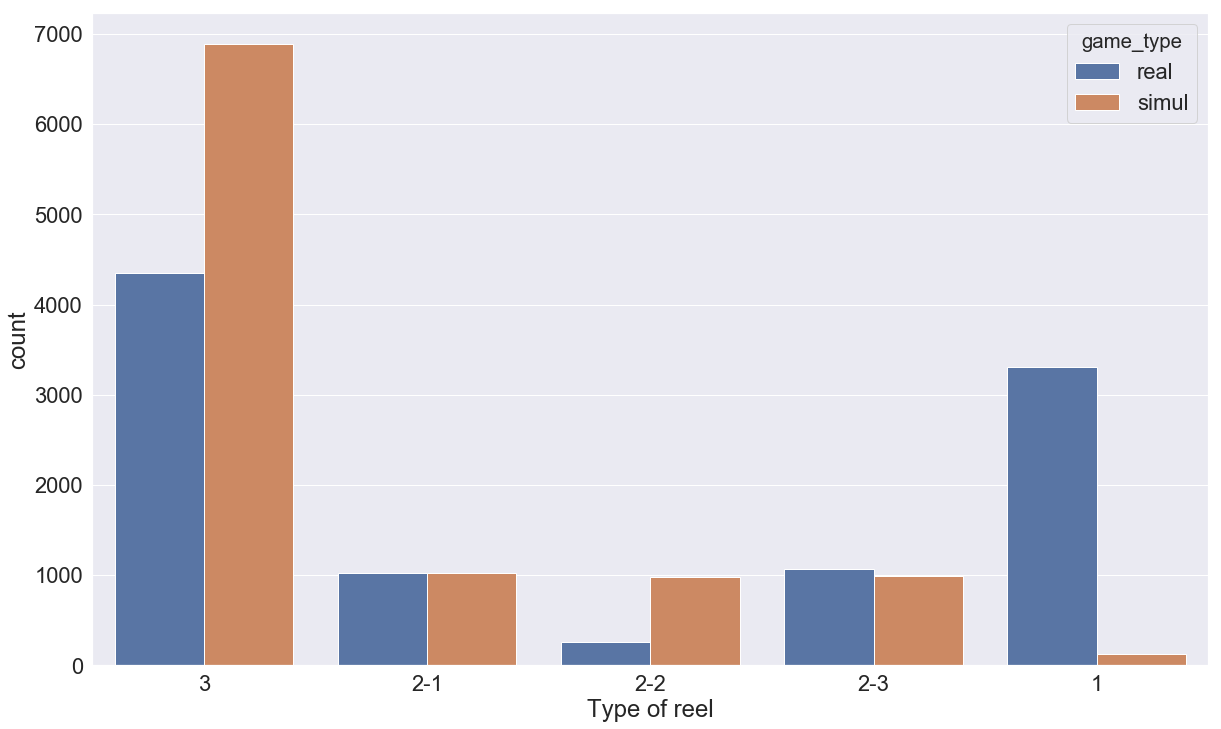

In [400]:
# 모든 reel의 reel_type 시각화

plt.figure(figsize=(20,12))
sns.countplot(x='reel_type', data=df_ms_rtype, order=['3', '2-1', '2-2', '2-3', '1'], hue='game_type')
plt.xlabel("Type of reel")
plt.show()

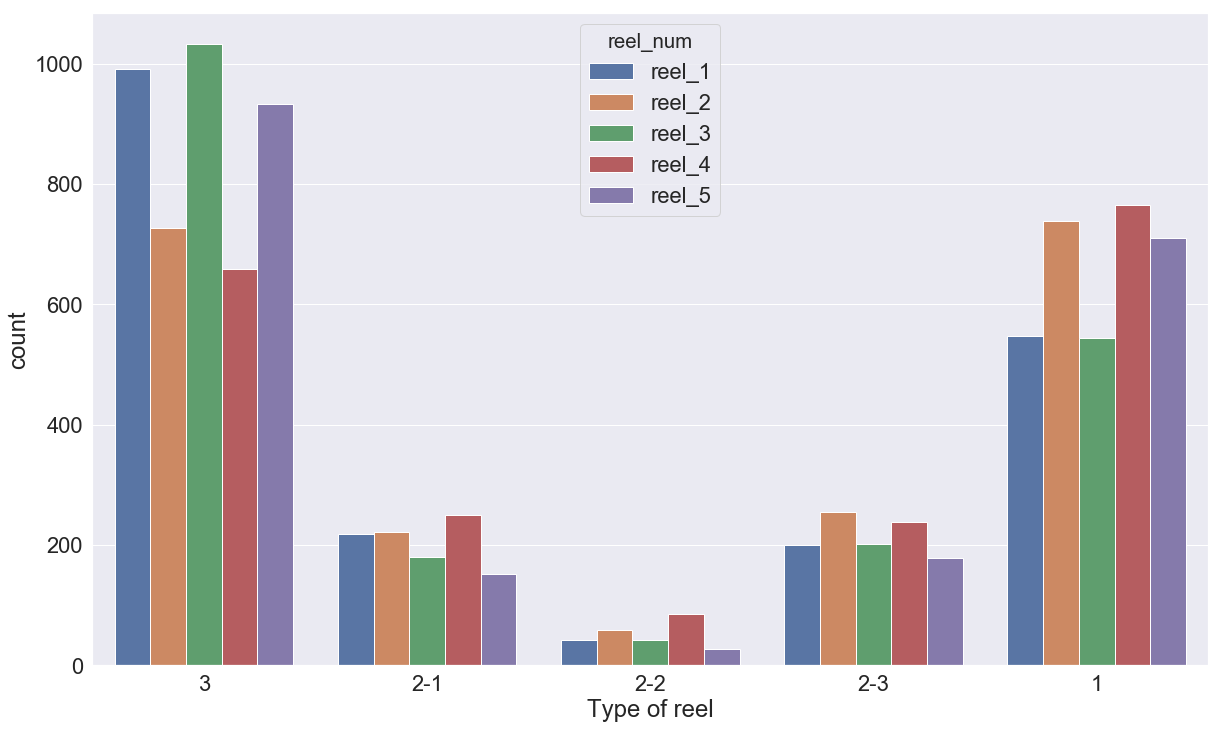

In [401]:
# 각 reel_num 별 reel_type 시각화

plt.figure(figsize=(20,12))
sns.countplot(x='reel_type', data=df_ms_rtype[df_ms_rtype['game_type']=='real'], hue='reel_num', order=['3', '2-1', '2-2', '2-3', '1'])
plt.xlabel("Type of reel")
plt.show()

In [191]:
# 실제 게임의 게임당 unique symbol의 개수를 담은 list를 생성

ms_real_unique_count = []

for i in range(2000):
    ms_real_unique_count.append(len(set(ms_slot_result_per_game[i])))

In [192]:
# 가상 게임의 게임당 unique symbol의 개수를 담은 list를 생성

ms_simul_unique_count = []

for i in range(2000):
    ms_simul_unique_count.append(len(set(ms_simul_result_per_game[i])))

In [198]:
df_ms_real_simul = pd.DataFrame(columns=['classname', 'game_type'])
df_ms_real_simul['classname'] = pd.concat([ms_slot_result['classname'], ms_simul_result['classname']])
df_ms_real_simul['game_type'] = ['real'] * len(ms_slot_result['classname']) + ['simul'] * len(ms_simul_result['classname'])
df_ms_real_simul = ms_real_simul_df.reset_index(drop=True)

In [197]:
# 비교를 위해 실제, 가상 결과를 담을 DataFrame을 생성

df_ms_unique_count = pd.DataFrame(columns=['unique_count', 'game_type'])
df_ms_unique_count['unique_count'] = ms_real_unique_count + ms_simul_unique_count
df_ms_unique_count['game_type'] = ['real'] * len(ms_real_unique_count) + ['simul'] * len(ms_simul_unique_count)

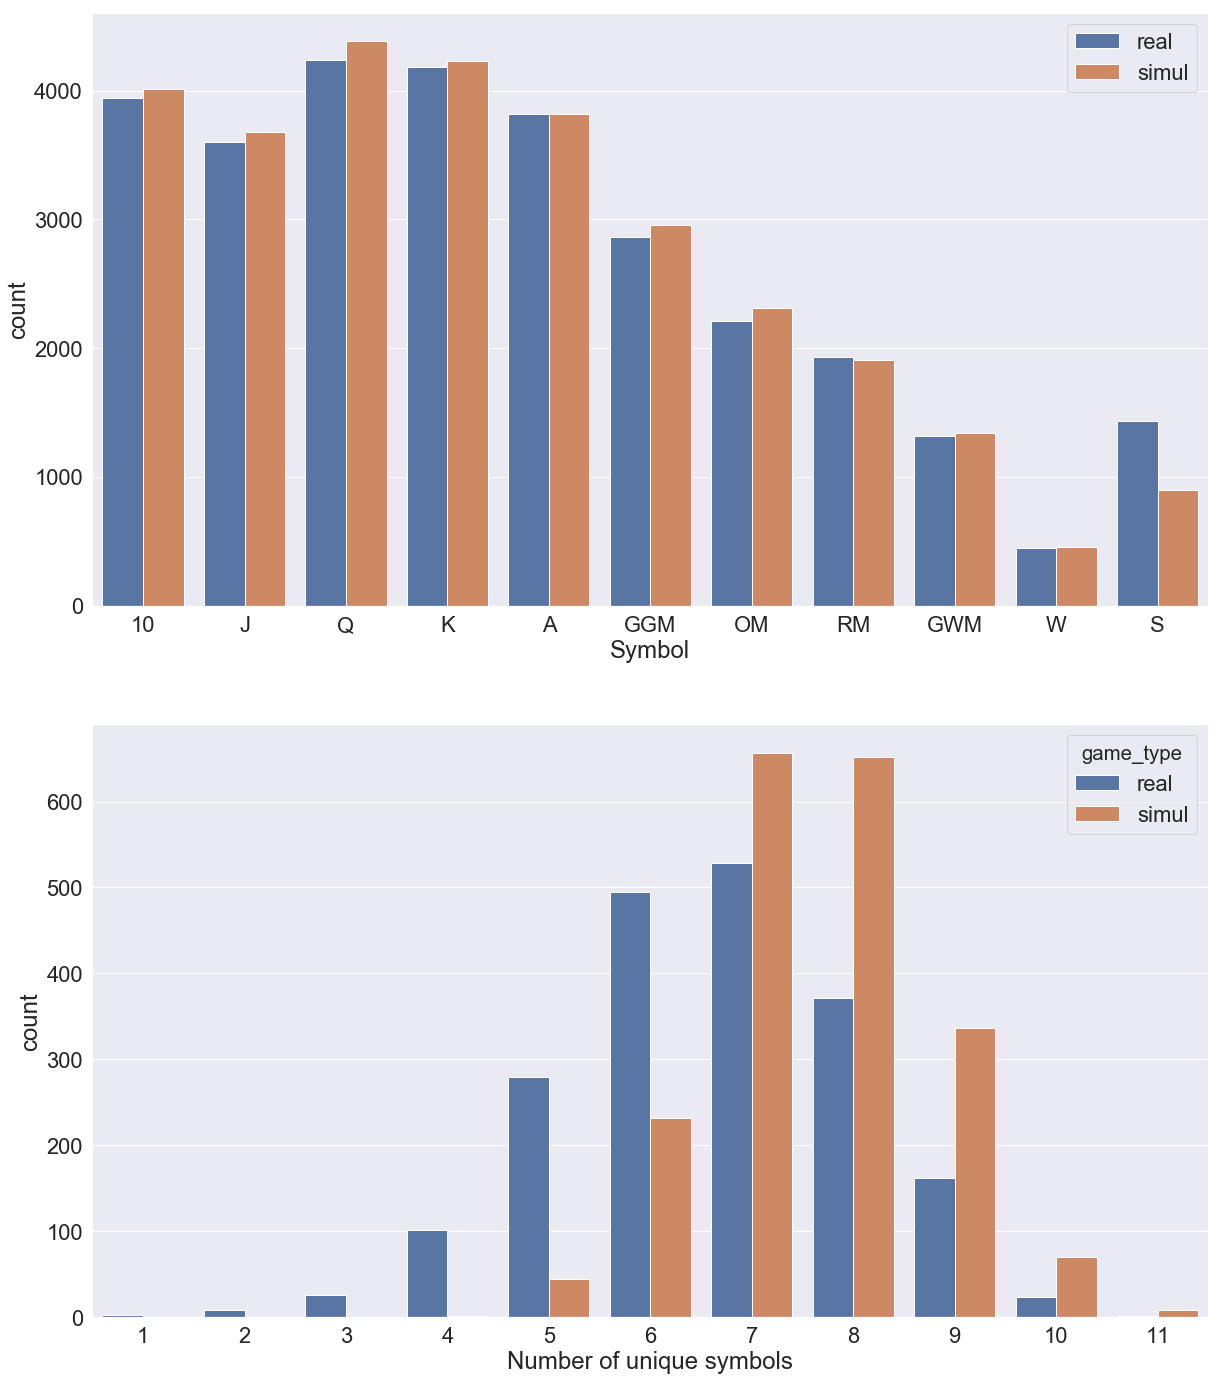

In [200]:
plt.figure(figsize=(20,24))
plt.subplot(2,1,1)
sns.countplot(x='classname', data=df_ms_real_simul, hue='game_type', order=ms_labels)
plt.xlabel('Symbol')

plt.legend()
plt.subplot(2,1,2)
sns.countplot(x='unique_count', data=df_ms_unique_count, hue='game_type')
plt.xlabel('Number of unique symbols')
plt.show()

# Masquerade

In [6]:
# csv 파일 불러오기

mq_slot_result = pd.read_csv('../data/slot_machine/masque_csv/mq_all.csv')
mq_slot_result.head()

,img,classname
0,masque_0_0.jpg,St
1,masque_0_1.jpg,Mn
2,masque_0_2.jpg,A
3,masque_0_3.jpg,A
4,masque_0_4.jpg,K


In [16]:
mq_labels = ['J', 'Q', 'K', 'A', 'F', 'H', 'Ms', 'St', 'Mn', 'Wm', 'Sc', 'W']

In [17]:
# 각 칸의 결과마다 game, row, col column 생성

mq_slot_result_game = [int(i_name.split('_')[1]) for n, i_name in enumerate(mq_slot_result['img'])]
mq_slot_result_row = [int(i_name.split('_')[2].split('.')[0]) % 3 + 1 for n, i_name in enumerate(mq_slot_result['img'])]
mq_slot_result_col = [int(i_name.split('_')[2].split('.')[0]) // 3 + 1 for n, i_name in enumerate(mq_slot_result['img'])]

mq_slot_result['game'] = mq_slot_result_game
mq_slot_result['row'] = mq_slot_result_row
mq_slot_result['col'] = mq_slot_result_col

mq_slot_result.head(15)

,img,classname,game,row,col
0,masque_0_0.jpg,St,0,1,1
1,masque_0_1.jpg,Mn,0,2,1
2,masque_0_2.jpg,A,0,3,1
3,masque_0_3.jpg,A,0,1,2
4,masque_0_4.jpg,K,0,2,2
5,masque_0_5.jpg,J,0,3,2
6,masque_0_6.jpg,F,0,1,3
7,masque_0_7.jpg,St,0,2,3
8,masque_0_8.jpg,K,0,3,3
9,masque_0_9.jpg,Wm,0,1,4


In [18]:
tmp = []
mq_slot_result_per_game = []
for n, x in enumerate(mq_slot_result['classname']):
    tmp.append(x)
    if (n+1) % 15 == 0:
        mq_slot_result_per_game.append(tmp)
        tmp = []

In [19]:
# 각 Symbol의 출현 확률의 구체적인 수치 (%)

mq_slot_result['classname'].value_counts() / len(mq_slot_result) * 100

J     13.430000
K     13.050000
A     12.296667
Q     12.060000
F     10.396667
H      9.200000
Ms     8.403333
St     7.413333
Wm     4.370000
Mn     3.893333
Sc     3.800000
W      1.686667
Name: classname, dtype: float64

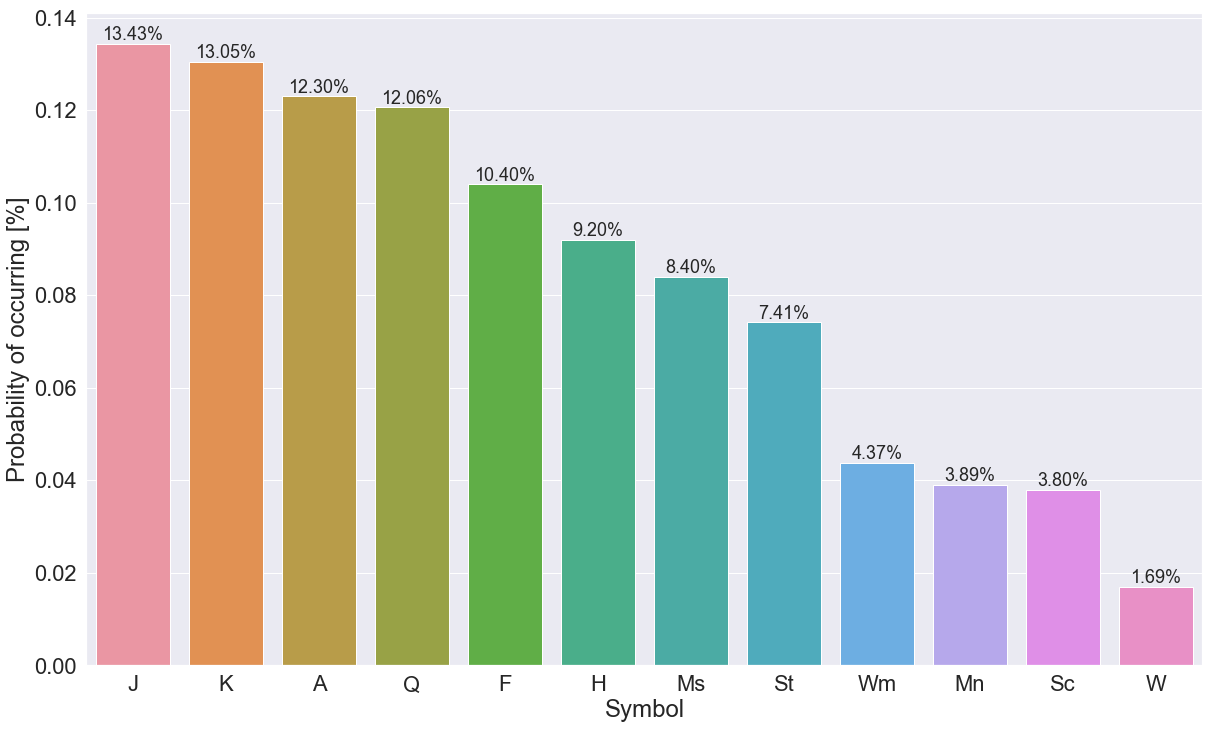

In [20]:
# 각 Symbol의 출현 확률 시각화

plt.figure(figsize=(20,12))
ax = sns.barplot(x=mq_slot_result['classname'].value_counts().index, y=mq_slot_result['classname'].value_counts() / len(mq_slot_result))
plt.xlabel("Symbol")
plt.ylabel("Probability of occurring [%]")


for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.2f}%'.format(y*100), (x.mean(), y), ha='center', va='bottom', fontsize=18) # set the alignment of the text

plt.show()

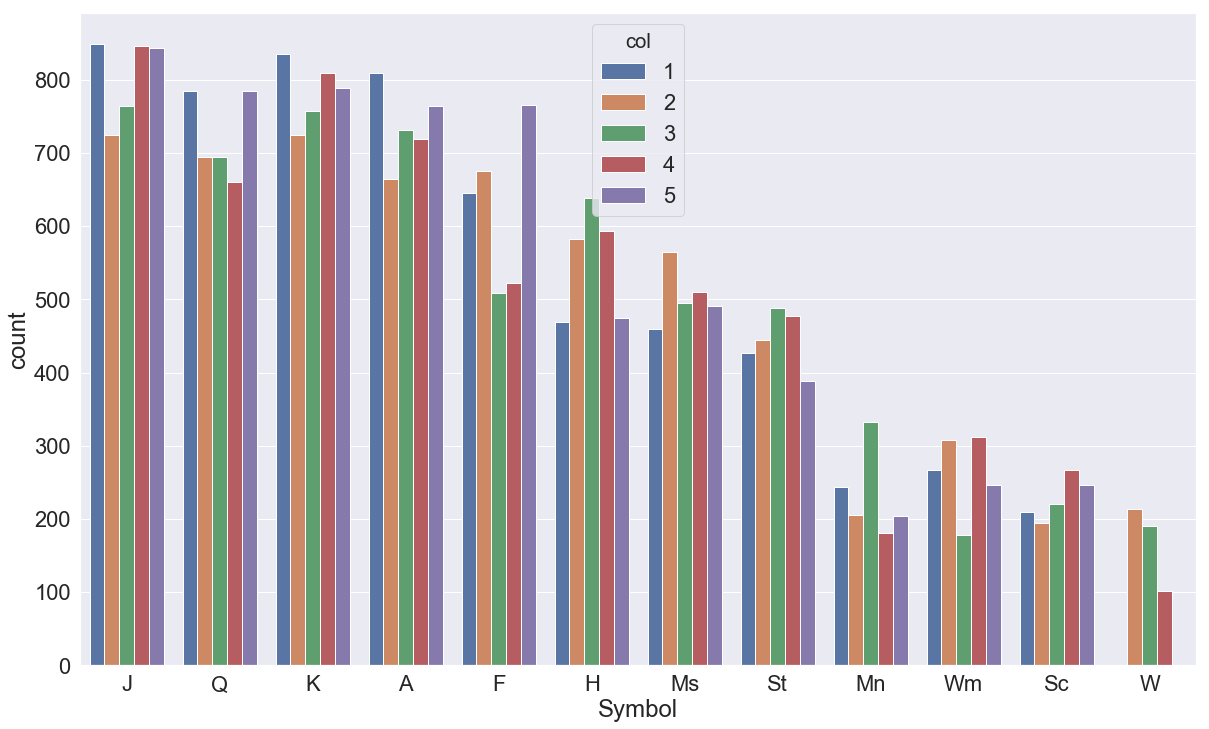

In [21]:
# 각 reel별 출현 횟수 시각화

plt.figure(figsize=(20,12))
sns.countplot(x='classname', data=mq_slot_result, hue='col', order=mq_labels)
plt.xlabel("Symbol")
plt.show()

In [74]:
mq_slot_result[mq_slot_result['classname'] == 'Sc']['col'].value_counts() / len(mq_slot_result[mq_slot_result['classname'] == 'Sc']['col'])

4    0.234211
5    0.216667
3    0.193860
1    0.184211
2    0.171053
Name: col, dtype: float64

In [38]:
'''
# Baseline Model

Masque Slot 2000번의 실제 게임 데이터를 기반으로 각 Symbol의 출현 빈도 설정 (근사치)

# J   : 13.5 %
# K   : 13 %
# A   : 12 %
# Q   : 12 %
# F   : 10.5 %
# H   : 9 %
# Ms  : 8.5 %
# St  : 7.5 %
# Wm  : 4.5 %
# Mn  : 4 %
# Sc  : 4%
# W   : 1.5 %
'''

# numpy의 randint를 통해 출현 확률을 기반으로 Symbol을 Return하는 함수

def getMasqueSymbol(start, end):
    i = np.random.randint(start, end)
    if i <= 27:
        return 'J'
    elif i <= 53 and i > 27:
        return 'K'
    elif i <= 77 and i > 53:
        return 'A'
    elif i <= 101 and i > 77:
        return 'Q'
    elif i <= 122 and i > 101:
        return 'F'
    elif i <= 140 and i > 122:
        return 'H'
    elif i <= 157 and i > 140:
        return 'Ms'
    elif i <= 172 and i > 157:
        return 'St'
    elif i <= 181 and i > 172:
        return 'Wm'
    elif i <= 189 and i > 181:
        return 'Mn'
    elif i <= 197 and i > 189:
        return 'Sc'
    elif i > 197:
        return 'W'

# 1회의 Spin 실행을 구현한 함수

def spin_masque():
    game = []
    start = 1
    
    for i in range(15):
        # 각 15개의 칸에 Symbol 추가
        if game.count('Sc') >= (i // 3 + 1):
            end = 190
            game.append(getMasqueSymbol(start, end))
        else:
            end = 201
            game.append(getMasqueSymbol(start, end))
    return game

In [39]:
spin_masque()

['A',
 'A',
 'J',
 'J',
 'W',
 'Sc',
 'A',
 'J',
 'Sc',
 'H',
 'St',
 'Ms',
 'Q',
 'St',
 'J']

In [40]:
# 실행 결과를 담을 list
mq_simul_result_per_game = []

# 2000번의 게임을 실행
for i in range(2000):
    mq_simul_result_per_game.append(spin_masque())

# 실제 게임 플레이 DataFrame을 불러와서 가상 게임플레이 데이터로 변경

mq_simul_result = mq_slot_result[['classname', 'game', 'row', 'col']]

mq_simul_classname = []

for game in mq_simul_result_per_game:
    for x in game:
        mq_simul_classname.append(x)

mq_simul_result['classname'] = mq_simul_classname

mq_simul_result.head(15)

C:\Users\Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,classname,game,row,col
0,J,0,1,1
1,Sc,0,2,1
2,A,0,3,1
3,St,0,1,2
4,H,0,2,2
5,K,0,3,2
6,Wm,0,1,3
7,St,0,2,3
8,A,0,3,3
9,J,0,1,4


## Scatter

In [45]:
# 실제 게임의 게임당 SCATTER 출현 횟수를 담은 list를 생성

mq_real_scatter_count =  []
for game in mq_slot_result_per_game:
    mq_real_scatter_count.append(game.count('Sc'))

# 실제 게임의 Spin당 RICHHITS의 출현 갯수

pd.Series(mq_real_scatter_count).value_counts()

0    1085
1     712
2     183
3      18
4       2
dtype: int64

In [70]:
# 가상 게임의 게임당 SCATTER 출현 횟수를 담은 list를 생성

mq_simul_scatter_count = []
for game in mq_simul_result_per_game:
    mq_simul_scatter_count.append(game.count('Sc'))

# 가상 게임의 Spin당 RICHHITS의 출현 갯수

pd.Series(mq_simul_scatter_count).value_counts() / 2000

0    0.5485
1    0.3295
2    0.1030
3    0.0170
4    0.0020
dtype: float64

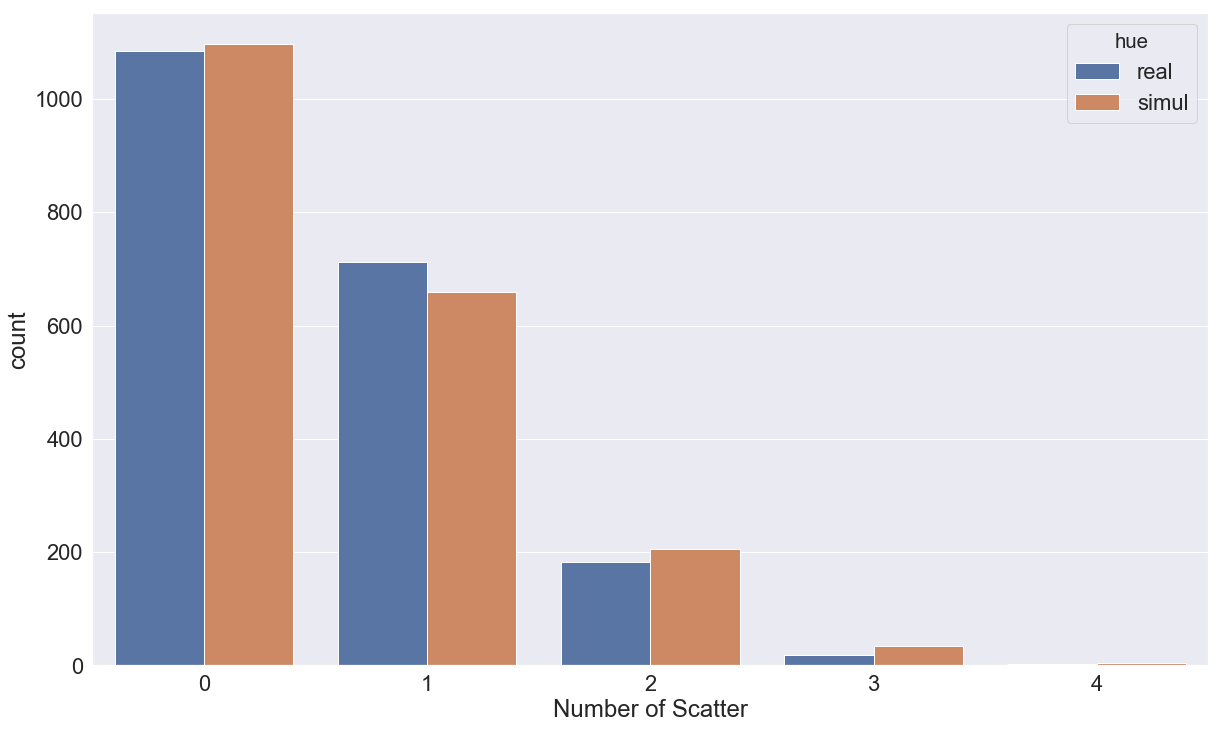

In [47]:
# 비교를 위해 실제, 가상 결과를 담을 DataFrame을 생성

df_mq_scatter = pd.DataFrame(columns=['scatter_count', 'hue'])
df_mq_scatter['scatter_count'] = mq_real_scatter_count + mq_simul_scatter_count
df_mq_scatter['hue'] = ['real'] * 2000 + ['simul'] * 2000

# 실제, 가상의 각 게임당 SCATTER 갯수 시각화

plt.figure(figsize=(20,12))
sns.countplot(x='scatter_count', data=df_mq_scatter, hue='hue')
plt.xlabel("Number of Scatter")
plt.show()

In [48]:
def getReelInfo(df, reel):
    row_type = []
    reel_symbols = []
    r_list = []
    s = ''
    for n, row in enumerate(df[df['col'] == reel]['classname']):
        r_list.append(row)
        s += row
        if not (n + 1) % 3:
            if r_list[0] == r_list [1] and r_list[1] == r_list[2]:
                row_type.append('1')
            elif r_list[0] == r_list[1] and r_list[0] != r_list[2] and r_list[1] != r_list[2]:
                row_type.append('2-1')
            elif r_list[0] == r_list[2] and r_list[0] != r_list[1] and r_list[2] != r_list[1]:
                row_type.append('2-2')
            elif r_list[1] == r_list[2] and r_list[1] != r_list[0] and r_list[2] != r_list[0]:
                row_type.append('2-3')
            else:
                row_type.append('3')
            r_list = []
            reel_symbols.append(s)
            s= ''
    return row_type, reel_symbols

In [49]:
# 실제 게임의 각 reel의 유형, symbol 저장

mq_real_reel1_rtype, mq_real_reel1_rsymbols = getReelInfo(mq_slot_result, 1)
mq_real_reel2_rtype, mq_real_reel2_rsymbols = getReelInfo(mq_slot_result, 2)
mq_real_reel3_rtype, mq_real_reel3_rsymbols = getReelInfo(mq_slot_result, 3)
mq_real_reel4_rtype, mq_real_reel4_rsymbols = getReelInfo(mq_slot_result, 4)
mq_real_reel5_rtype, mq_real_reel5_rsymbols = getReelInfo(mq_slot_result, 5)

mq_real_reel_rtype = mq_real_reel1_rtype + mq_real_reel2_rtype + mq_real_reel3_rtype+ mq_real_reel4_rtype + mq_real_reel5_rtype 


# 가상 게임의 각 reel의 유형, symbol 저장

mq_simul_reel1_rtype, mq_simul_reel1_rsymbols = getReelInfo(mq_simul_result, 1)
mq_simul_reel2_rtype, mq_simul_reel2_rsymbols = getReelInfo(mq_simul_result, 2)
mq_simul_reel3_rtype, mq_simul_reel3_rsymbols = getReelInfo(mq_simul_result, 3)
mq_simul_reel4_rtype, mq_simul_reel4_rsymbols = getReelInfo(mq_simul_result, 4)
mq_simul_reel5_rtype, mq_simul_reel5_rsymbols = getReelInfo(mq_simul_result, 5)

mq_simul_reel_rtype = mq_simul_reel1_rtype + mq_simul_reel2_rtype + mq_simul_reel3_rtype + mq_simul_reel4_rtype + mq_simul_reel5_rtype


# 비교를 위해 실제 게임 데이터의 reel_type을 담을 DataFrame을 생성

df_mq_rtype = pd.DataFrame(columns=['reel_type', 'reel_num', 'game_type'])
df_mq_rtype['reel_type'] = mq_real_reel_rtype + mq_simul_reel_rtype
df_mq_rtype['reel_num'] = (['reel_1'] * 2000 + ['reel_2'] * 2000 + ['reel_3'] * 2000 + ['reel_4'] * 2000 + ['reel_5'] * 2000) * 2
df_mq_rtype['game_type'] = ['real'] * 10000 + ['simul'] * 10000

df_mq_rtype.head()

,reel_type,reel_num,game_type
0,3,reel_1,real
1,3,reel_1,real
2,3,reel_1,real
3,3,reel_1,real
4,3,reel_1,real


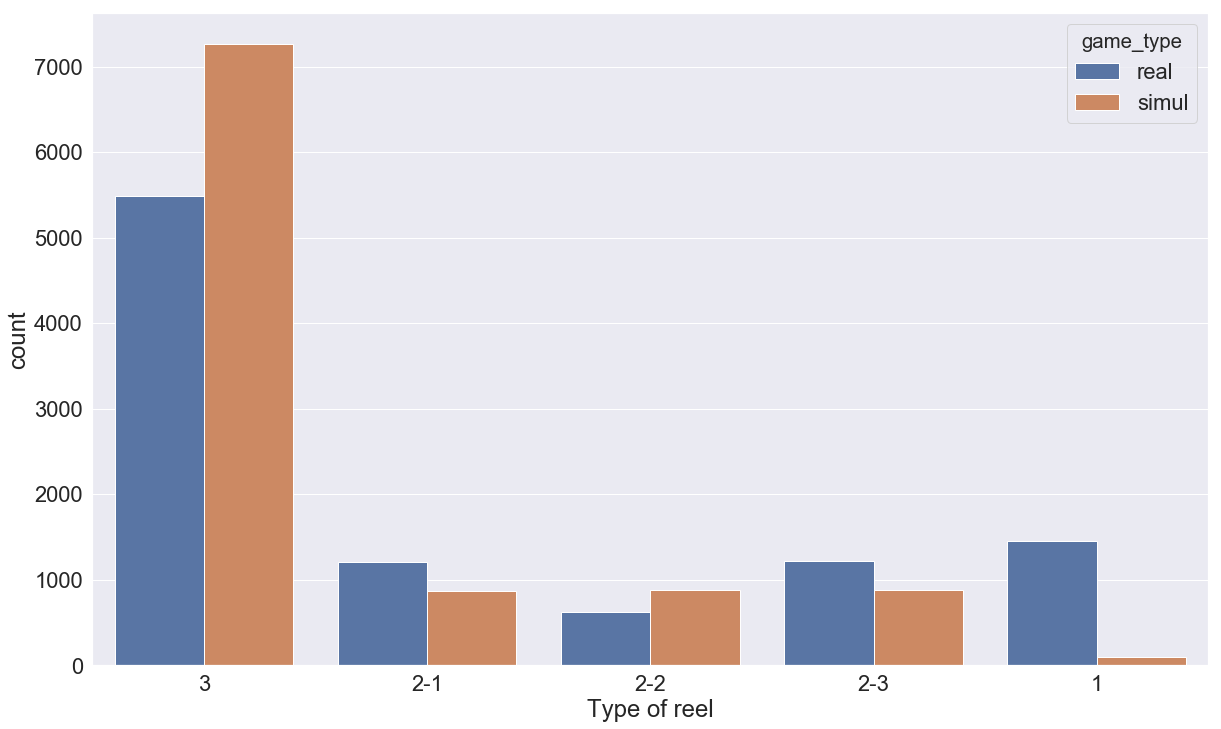

In [51]:
# 모든 reel의 reel_type 시각화

plt.figure(figsize=(20,12))
sns.countplot(x='reel_type', data=df_mq_rtype, order=['3', '2-1', '2-2', '2-3', '1'], hue='game_type')
plt.xlabel("Type of reel")
plt.show()

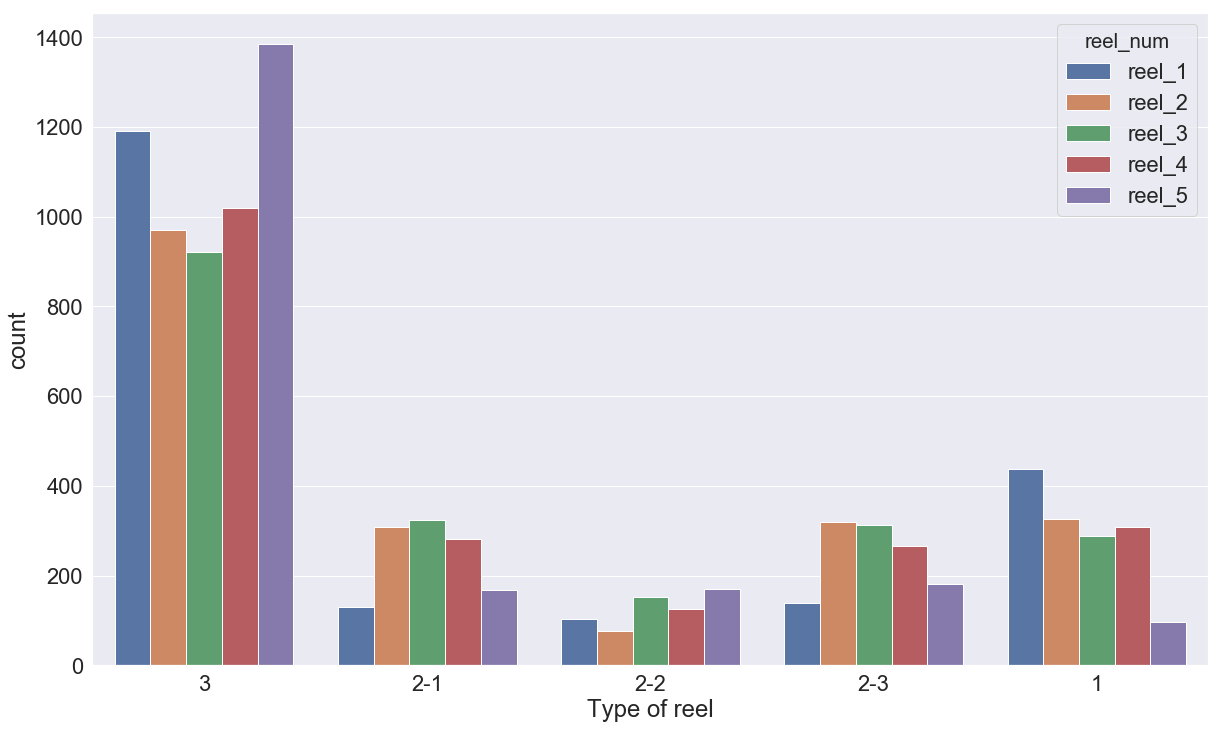

In [52]:
# 각 reel_num 별 reel_type 시각화

plt.figure(figsize=(20,12))
sns.countplot(x='reel_type', data=df_mq_rtype[df_mq_rtype['game_type']=='real'], hue='reel_num', order=['3', '2-1', '2-2', '2-3', '1'])
plt.xlabel("Type of reel")
plt.show()

In [59]:
mq_tmp[mq_tmp['reel_num'] == 1]

,reel_type,reel_num,game_type


In [69]:
mq_tmp = df_mq_rtype[df_mq_rtype['game_type']=='real']
mq_tmp[mq_tmp['reel_num'] == 'reel_5']['reel_type'].value_counts() / 2000

3      0.6925
2-3    0.0905
2-2    0.0850
2-1    0.0840
1      0.0480
Name: reel_type, dtype: float64

In [53]:
# 실제 게임의 게임당 unique symbol의 개수를 담은 list를 생성

mq_real_unique_count = []

for i in range(2000):
    mq_real_unique_count.append(len(set(mq_slot_result_per_game[i])))


# 가상 게임의 게임당 unique symbol의 개수를 담은 list를 생성

mq_simul_unique_count = []

for i in range(2000):
    mq_simul_unique_count.append(len(set(mq_simul_result_per_game[i])))


# 실제 게임 데이터와 가상 게임 데이터 병합
df_mq_real_simul = pd.DataFrame(columns=['classname', 'game_type'])
df_mq_real_simul['classname'] = pd.concat([mq_slot_result['classname'], mq_simul_result['classname']])
df_mq_real_simul['game_type'] = ['real'] * len(mq_slot_result['classname']) + ['simul'] * len(mq_simul_result['classname'])
df_mq_real_simul = df_mq_real_simul.reset_index(drop=True)


# 비교를 위해 unique symbol의 실제, 가상 결과를 담을 DataFrame을 생성

df_mq_unique_count = pd.DataFrame(columns=['unique_count', 'game_type'])
df_mq_unique_count['unique_count'] = mq_real_unique_count + mq_simul_unique_count
df_mq_unique_count['game_type'] = ['real'] * len(mq_real_unique_count) + ['simul'] * len(mq_simul_unique_count)

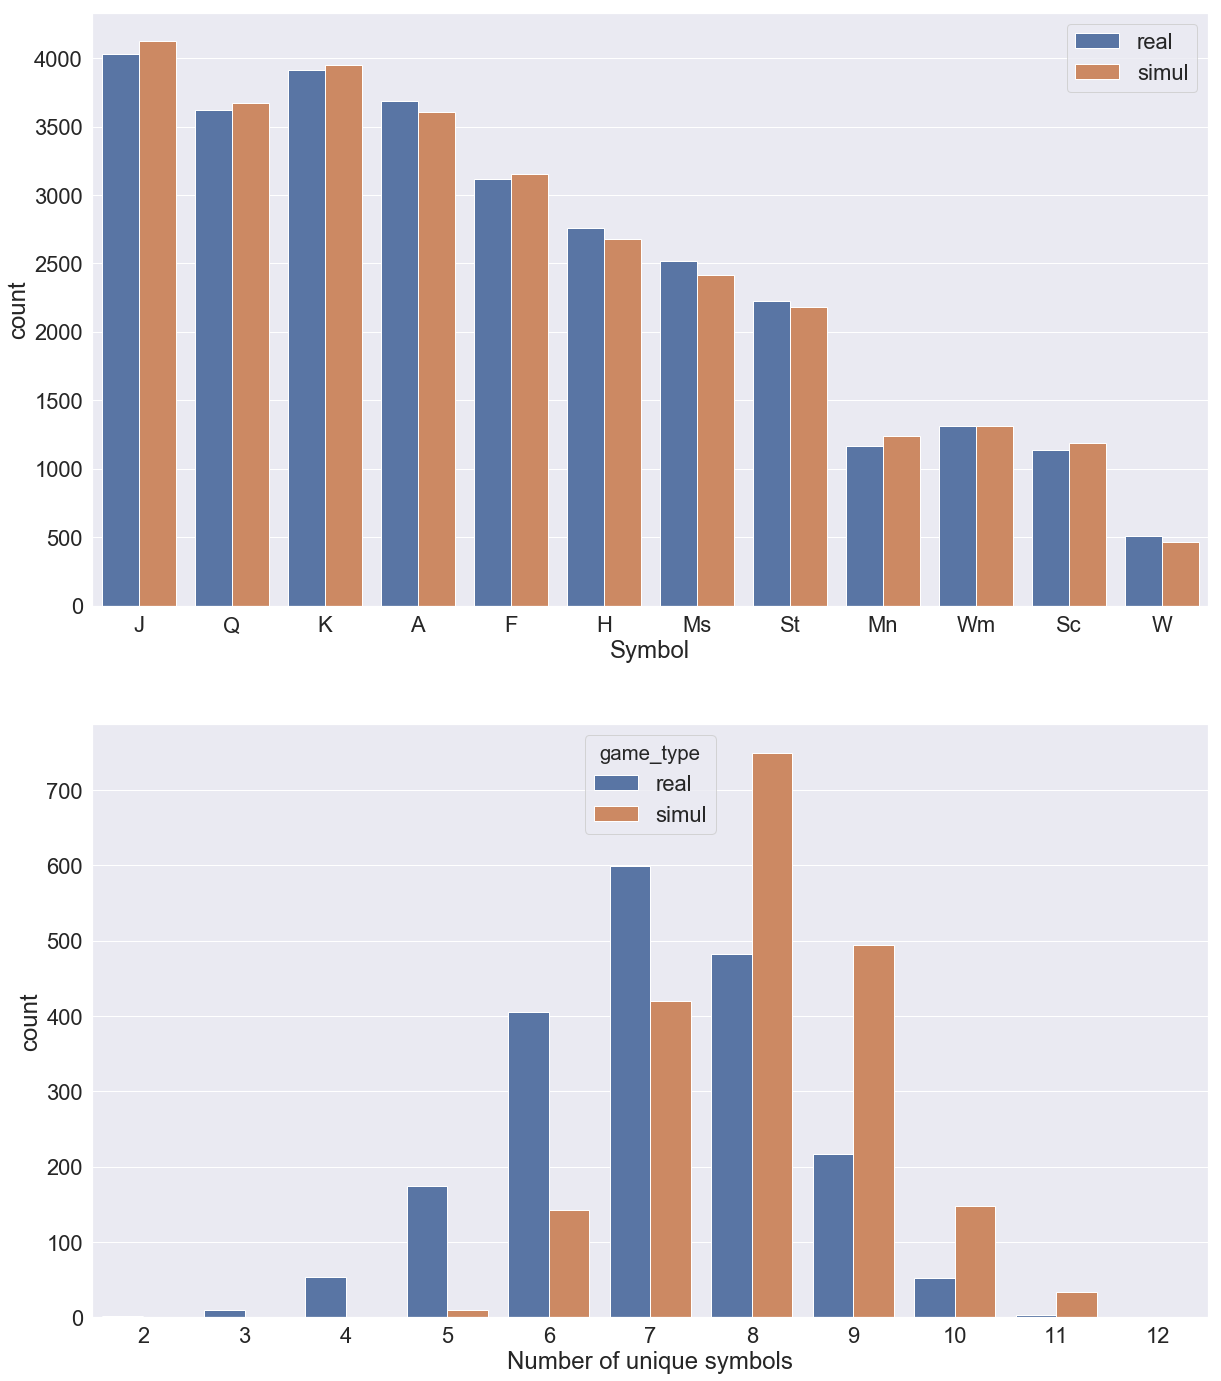

In [54]:
plt.figure(figsize=(20,24))
plt.subplot(2,1,1)
sns.countplot(x='classname', data=df_mq_real_simul, hue='game_type', order=mq_labels)
plt.xlabel('Symbol')

plt.legend()
plt.subplot(2,1,2)
sns.countplot(x='unique_count', data=df_mq_unique_count, hue='game_type')
plt.xlabel('Number of unique symbols')
plt.show()